In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import os
while os.path.split(os.getcwd())[1] != "unrolling":
    os.chdir("..")
    if os.getcwd() == "/":
        raise ValueError()
print("Current working directory: {}".format(os.getcwd()))

import sys
PATH ='./codes/'
sys.path.insert(1,PATH)

import IAE_CNN_TORCH_v2 as cnn
import LPALM_LS
import LPALM
import LFBS
from utils import generate_dataset

import torch
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
import time

from sklearn.decomposition import PCA

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Fixing random state for reproducibility
np.random.seed(19680801)


if torch.cuda.is_available():
    device = 'cuda'
    kwargs = {}
    acc = "gpu"
    Xpus_per_trial = 1
else:
    device = 'cpu'
    kwargs = {}
    acc = 'cpu'
    Xpus_per_trial = 1

print("device USED: ",device)

Current working directory: /feynman/work/dedip/lilas/wf274757/unrolling
device USED:  cuda


In [3]:
# from utils import generate_dataset_with_amp

# model_IAE = cnn.load_model('Models/cnn_test')
# Y, A, X = generate_dataset(model_IAE, nb_samples=1000,amplitude_range=2.)
# np.save('data/Xtrain_amp2.npy',X)
# np.save('data/Ytrain_amp2.npy',Y)
# np.save('data/Atrain_amp2.npy',A)
# Y, A, X = generate_dataset(model_IAE, nb_samples=500,amplitude_range=2.)
# np.save('data/Xval_amp2.npy',X)
# np.save('data/Yval_amp2.npy',Y)
# np.save('data/Aval_amp2.npy',A)
Xtrain = np.load('data/Xtrain_amp2.npy')
Ytrain = np.load('data/Ytrain_amp2.npy')
Atrain = np.load('data/Atrain_amp2.npy')
Xval = np.load('data/Xval_amp2.npy')
Yval = np.load('data/Yval_amp2.npy')
Aval = np.load('data/Aval_amp2.npy')

In [4]:
Xtrain.max(), Xtrain.max(1).mean(), Xval.max(), Xval.max(1).mean(), 

(0.49286088, 0.4873327, 0.49281052, 0.48729816)

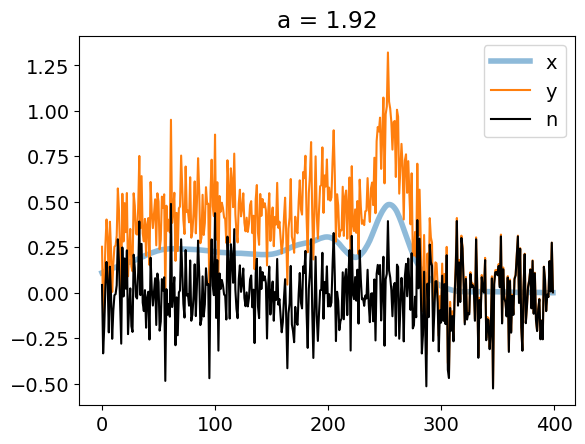

In [5]:
i=12
plt.plot(Xtrain[i,:,0].T,lw=4,alpha=0.5, label='x')
plt.plot(Ytrain[i,:,0].T, label='y')
plt.plot(Ytrain[i,:,0].T-Atrain[i,0]*Xtrain[i,:,0].T,'k', label='n')
plt.legend()
plt.title('a = %.2f'%Atrain[i,0])
# plt.savefig('./Figures/exmample_dataset_amp.png', bbox_inches='tight')
plt.show()

# plt.plot(model_IAE.anchorpoints[:,:,0].T, '--', color='black', label='Anchor points')
# plt.plot(Xtrain[:,:,0].T, alpha=0.5)
# plt.legend()
# # plt.savefig('./Figures/dataset_X.png', bbox_inches='tight')
# plt.show()

In [4]:
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytrain).float(), torch.from_numpy(Atrain).float(), torch.from_numpy(Xtrain).float()), batch_size=32)
val_dataloader = DataLoader(TensorDataset(torch.from_numpy(Yval).float(), torch.from_numpy(Aval).float(), torch.from_numpy(Xval).float()), batch_size=32)

## Evaluation

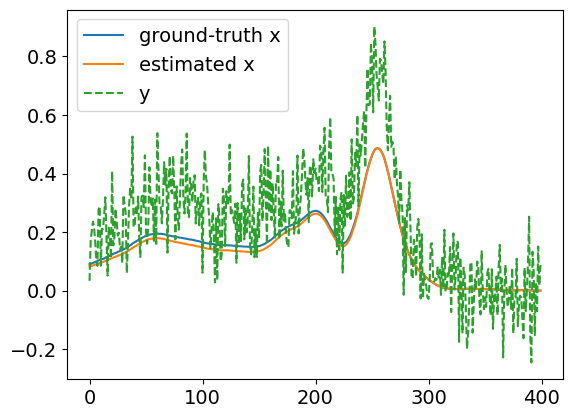

estimated amplitude: 1.19
real amplitude: 1.61


In [43]:
fname = './Models/model_LPALM_L3'
model_LPALM = load_model(fname, device=device)
# Ytest, Atest, Xtest= generate_dataset_with_amp(model_IAE, 1, noise_level = [_noise_level, _noise_level])

dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
A_pred_LPALM, X_pred_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
x = X_pred_LPALM[-1].cpu().detach().numpy() 
a = A_pred_LPALM[-1].cpu().detach().numpy()

plt.plot(Xtest.squeeze(),label='ground-truth x')
plt.plot(x.squeeze(),label='estimated x')
plt.plot(Ytest.squeeze(),'--',label='y')
plt.legend()
plt.show()
print('estimated amplitude: %.2f'%a)
print('real amplitude: %.2f'%Atest)

In [10]:
amplitude_range=10.
(amplitude_range*np.ones((5,1)))**((np.random.rand(5,1))*2-1)

array([[4.62472807],
       [0.28887609],
       [1.35633651],
       [0.33556851],
       [8.12751916]])

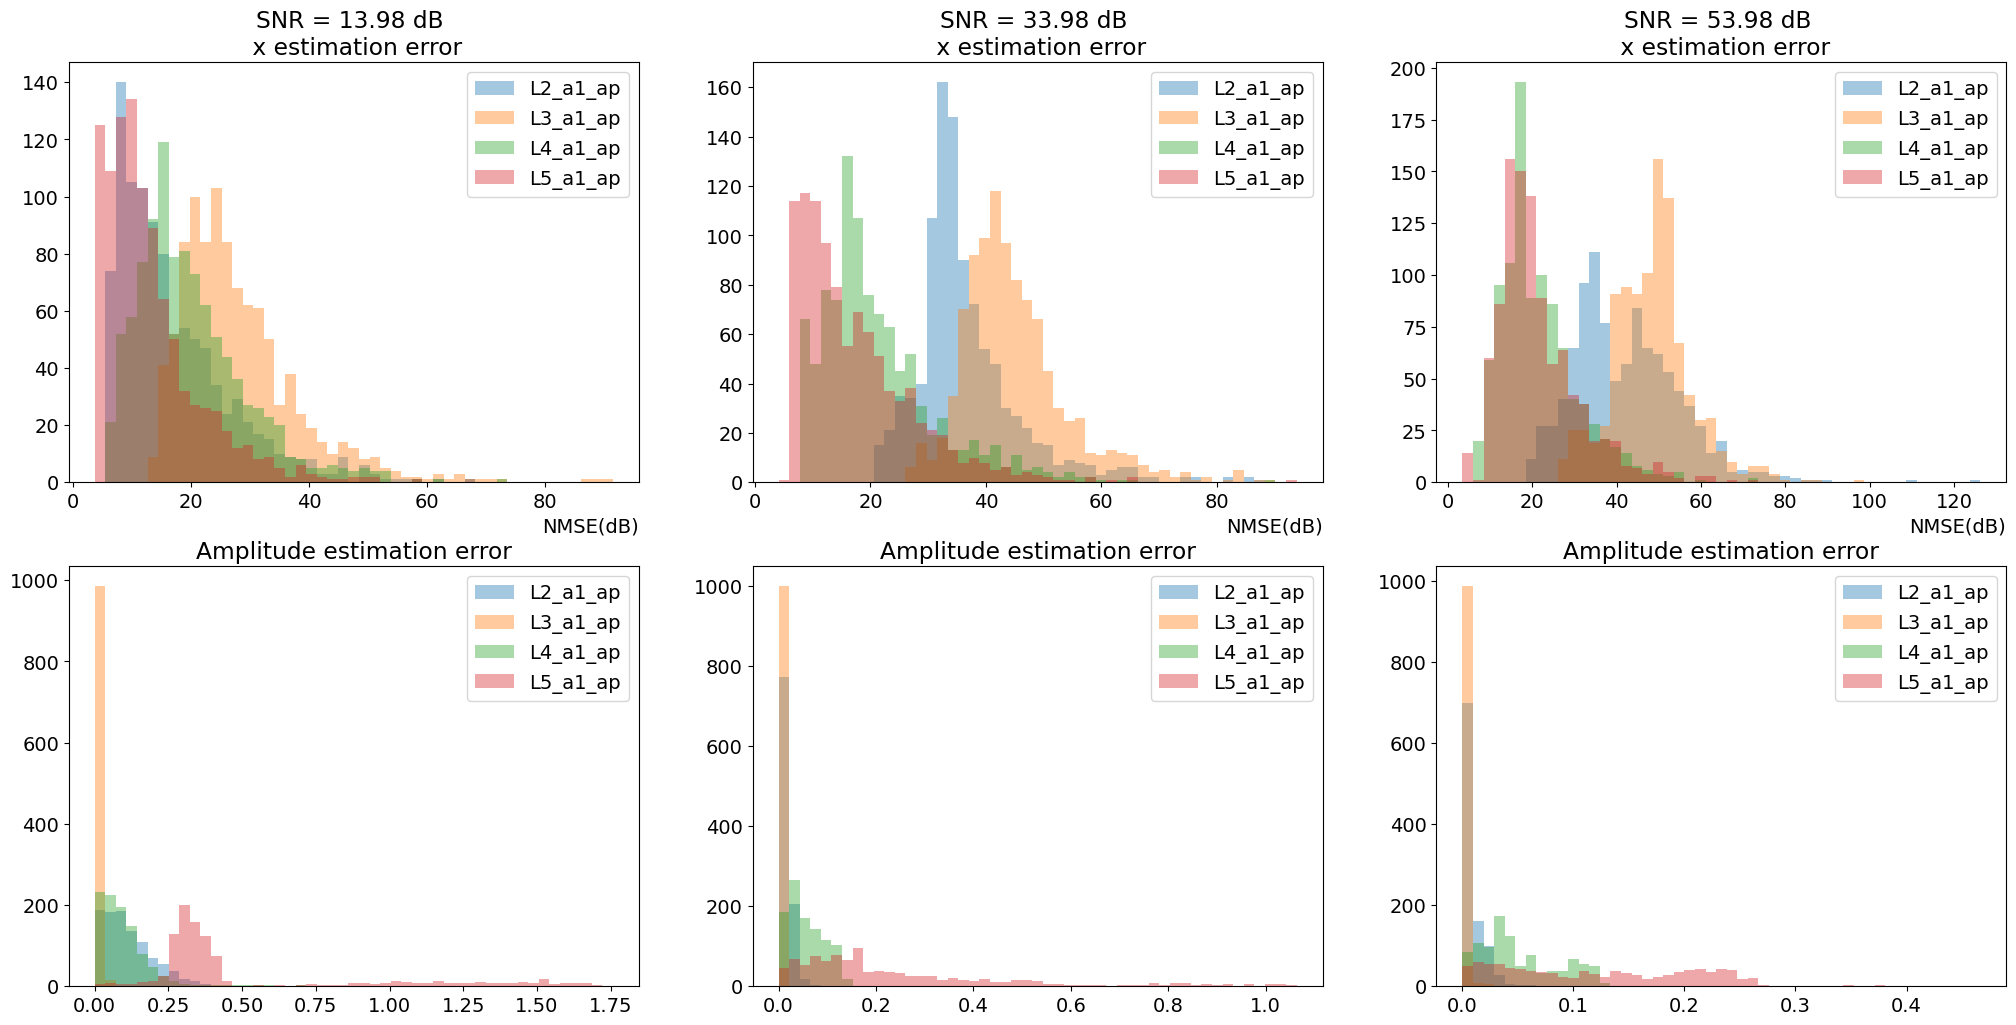

In [4]:
list_fname = ['Models/model_LPALM_L2_a1_ap',
              'Models/model_LPALM_L3_a1_ap',
              'Models/model_LPALM_L4_a1_ap',
              'Models/model_LPALM_L5_a1_ap']

# _noise_level=1e-1
plt.figure(figsize=(25,12))
j=0
for _noise_level in [1e-1, 1e-2, 1e-3]:
    list_nmse=[]
    list_err_A=[]
    for fname in list_fname:
        model_LPALM = load_model(fname, device=device)

        model_IAE = cnn.load_model(model_LPALM.iae_fname)

        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level])

        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
        A_pred_LPALM, X_pred_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        A_pred_LPALM = A_pred_LPALM[-1].cpu().detach().numpy()
        X_pred_LPALM = X_pred_LPALM[-1].cpu().detach().numpy()

        nmse_LPALM = -10*np.log10(np.sum((X_pred_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        list_nmse.append(nmse_LPALM)
        list_err_A.append(np.abs(A_pred_LPALM-Atest)/Atest)

    plt.subplot(2,3,j+1)
    bins = np.linspace(np.array(list_nmse).min(),np.array(list_nmse).max(),50)
    for i in range(len(list_nmse)):
        plt.hist(list_nmse[i],bins,alpha=0.4,label=list_fname[i][19:])
    plt.xlabel('NMSE(dB)',loc='right')
    plt.title('SNR = %.2f dB \n x estimation error' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    
    plt.subplot(2,3,j+4)
    bins = np.linspace(np.array(list_err_A).min(),np.array(list_err_A).max(),50)
    for i in range(len(list_err_A)):
        plt.hist(list_err_A[i],bins,alpha=0.4,label=list_fname[i][19:])

    plt.title('Amplitude estimation error')
    plt.legend()
    j += 1
# plt.savefig('./Figures/hist_amp1.png', bbox_inches='tight')


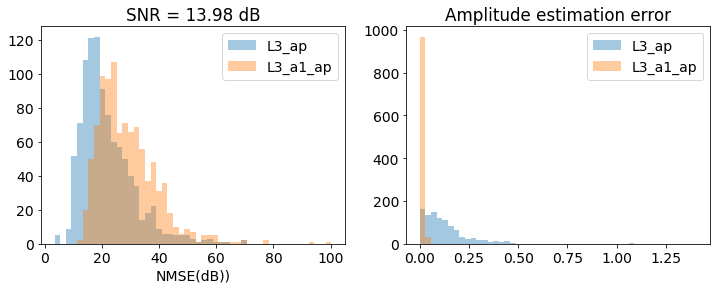

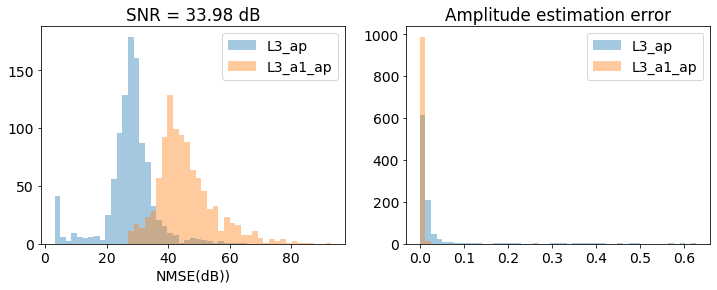

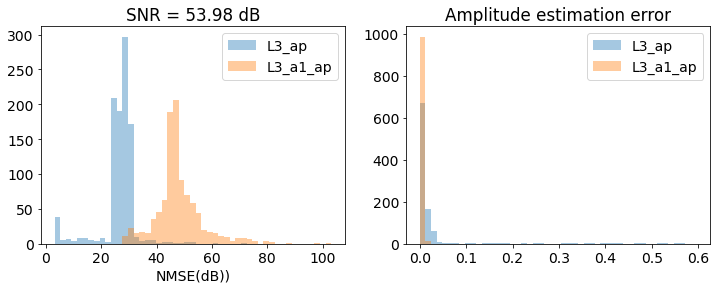

In [5]:
list_fname = ['Models/model_LPALM_L3_ap',
              'Models/model_LPALM_L3_a1_ap']

# _noise_level=1e-1
for _noise_level in [1e-1, 1e-2, 1e-3]:
    list_nmse=[]
    list_err_A=[]
    for fname in list_fname:
        model_LPALM = load_model(fname, device=device)

        model_IAE = cnn.load_model(model_LPALM.iae_fname)

        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level])

        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
        A_pred_LPALM, X_pred_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        A_pred_LPALM = A_pred_LPALM[-1].cpu().detach().numpy()
        X_pred_LPALM = X_pred_LPALM[-1].cpu().detach().numpy()

        nmse_LPALM = -10*np.log10(np.sum((X_pred_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        list_nmse.append(nmse_LPALM)
        list_err_A.append(np.abs(A_pred_LPALM-Atest)/Atest)


    plt.figure(figsize=(12,4))
    plt.subplot(121)
    bins = np.linspace(np.array(list_nmse).min(),np.array(list_nmse).max(),50)
    for i in range(len(list_nmse)):
        plt.hist(list_nmse[i],bins,alpha=0.4,label=list_fname[i][19:])
    plt.xlabel('NMSE(dB))')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    
#     plt.figure()    
    plt.subplot(122)
    bins = np.linspace(np.array(list_err_A).min(),np.array(list_err_A).max(),50)
    for i in range(len(list_err_A)):
        plt.hist(list_err_A[i],bins,alpha=0.4,label=list_fname[i][19:])

    plt.title('Amplitude estimation error')
    plt.legend()


Computation time with gpu: 13.808 s


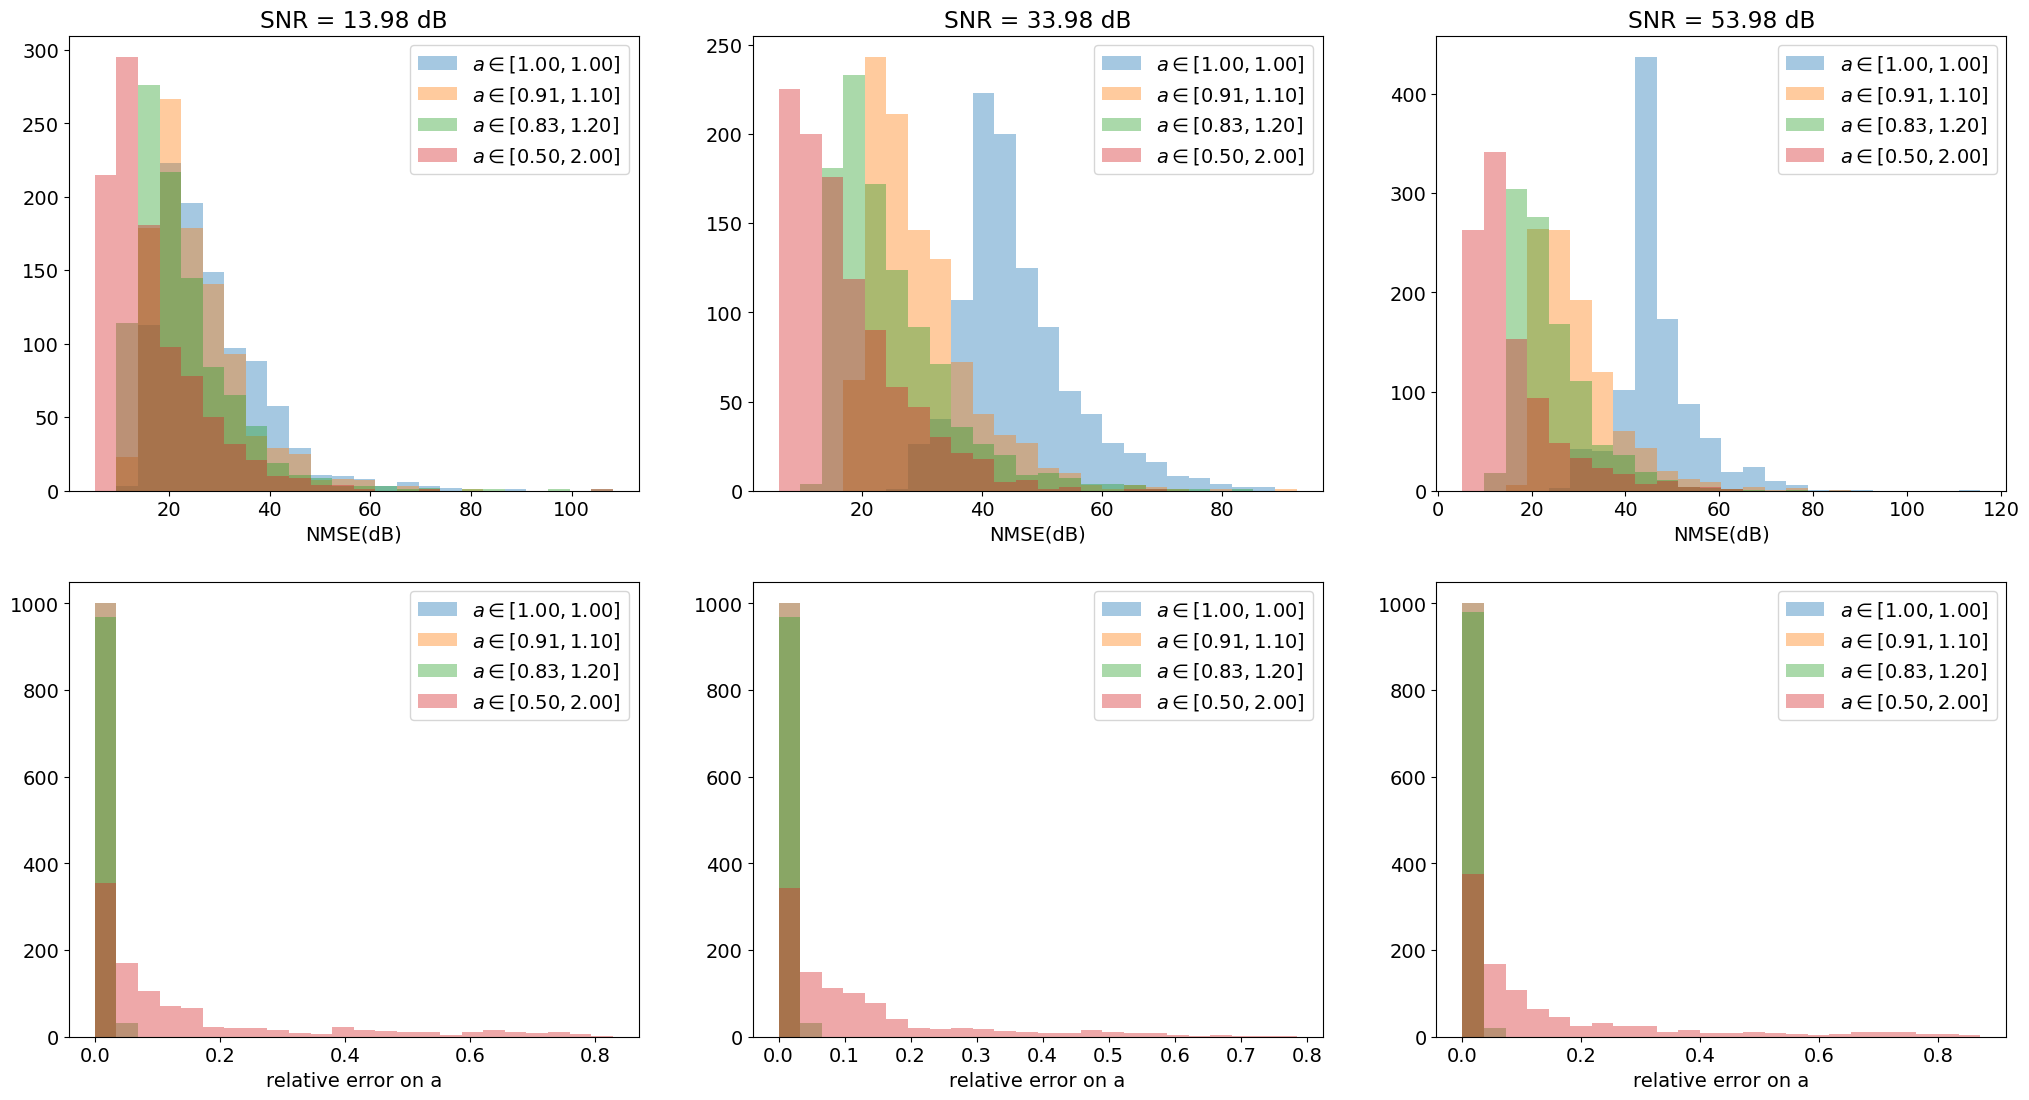

In [3]:
# test model on data with amplitude
t = time.time()
fname = 'Models/model_LPALM_L3_a1_ap'
model_LPALM = load_model(fname, device=device)
model_IAE = cnn.load_model(model_LPALM.iae_fname)
list_a = [1., 1.1, 1.2, 2.]

plt.figure(figsize=(25,13))
j=0
for _noise_level in [1e-1, 1e-2, 1e-3]:
    
    list_nmse_x=[]
    list_nmse_a=[]
    
    for a in list_a:

        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
        a_pred, x_pred = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_pred = a_pred[-1].cpu().detach().numpy()
        x_pred = x_pred[-1].cpu().detach().numpy()

        nmse_x = -10*np.log10(np.sum((x_pred-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a = np.sum((a_pred-Atest)**2, 1)/ np.sum(Atest**2, 1)
        list_nmse_x.append(nmse_x)
        list_nmse_a.append(nmse_a)
    plt.subplot(2,3,j+1)
    bins = np.linspace(np.array(list_nmse_x).min(),np.array(list_nmse_x).max(),25)
    i=0
    for a in list_a:
        plt.hist(list_nmse_x[i],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        i+=1
    plt.xlabel('NMSE(dB)')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    plt.subplot(2,3,j+4)
    bins = np.linspace(np.array(list_nmse_a).min(),np.array(list_nmse_a).max(),25)
    i=0
    for a in list_a:
        plt.hist(list_nmse_a[i],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        i+=1
    plt.xlabel('relative error on a')
    plt.legend()
    j+=1
plt.savefig('./Figures/hist_LPALM_a1.png', bbox_inches='tight')
            
print('Computation time with gpu: %.3f s'% (time.time()-t))

Computation time with gpu: 1.964 s


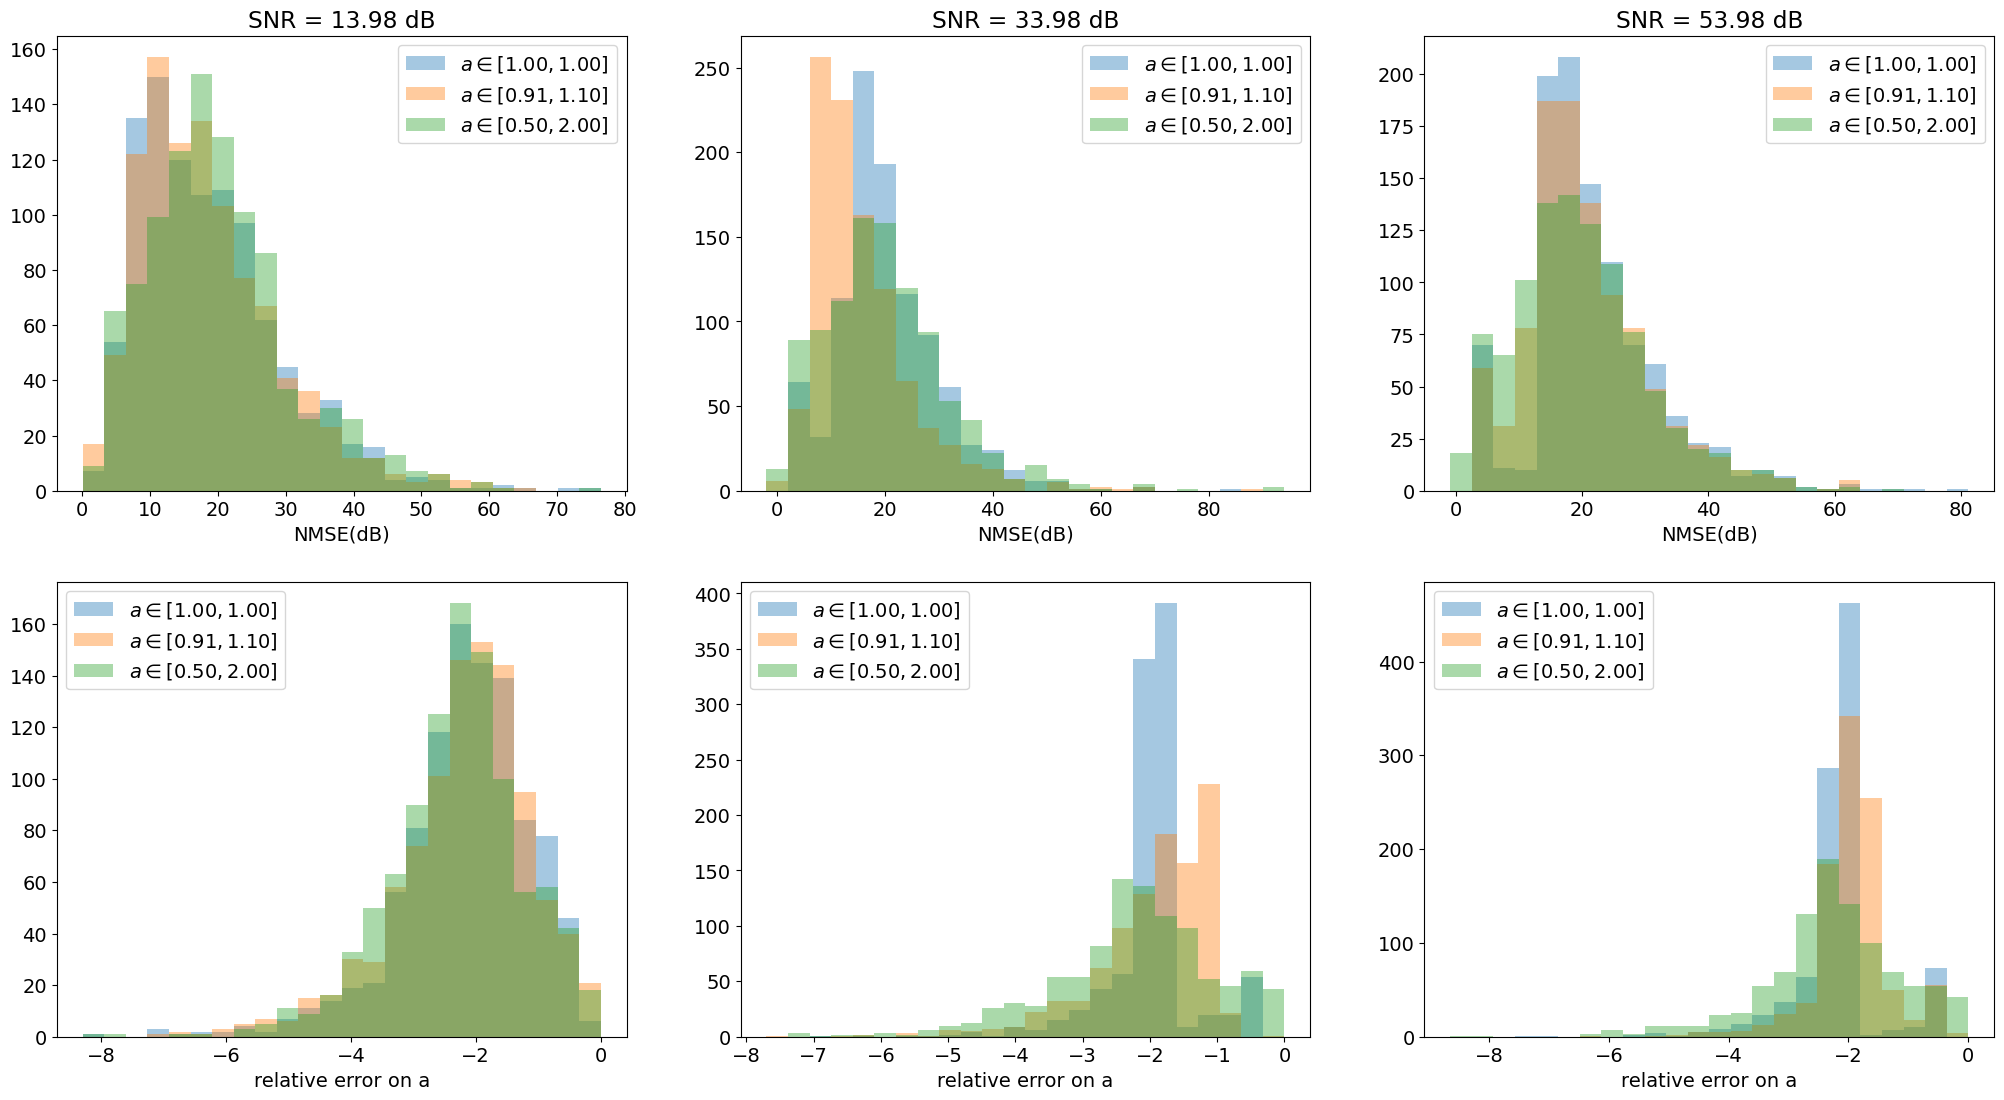

In [49]:
# test model on data with amplitude
t = time.time()
fname = 'Models/model_LPALM_L3_a2'
model_LPALM = LPALM.load_model(fname, device=device)
model_IAE = cnn.load_model(model_LPALM.iae_fname)
list_a = [1., 1.1, 2.]

plt.figure(figsize=(25,13))
j=0
for _noise_level in [1e-1, 1e-2, 1e-3]:
    noise_amp = np.abs(Ytest-np.einsum('ik,ijk->ijk',Atest, Xtest)).max(1)
    snr = np.einsum('ij,ij->i',noise_amp, 1./Atest)

    list_nmse_x=[]
    list_nmse_a=[]
    
    for a in list_a:

        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
        a_pred, x_pred = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_pred = a_pred[-1].cpu().detach().numpy()
        x_pred = x_pred[-1].cpu().detach().numpy()

        nmse_x = -10*np.log10(np.sum((x_pred-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a = np.log10(np.sum((a_pred-Atest)**2, 1)/ np.sum(Atest**2, 1))
        list_nmse_x.append(nmse_x)
        list_nmse_a.append(nmse_a)
    plt.subplot(2,3,j+1)
    bins = np.linspace(np.array(list_nmse_x).min(),np.array(list_nmse_x).max(),25)
    i=0
    for a in list_a:
        plt.hist(list_nmse_x[i],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        i+=1
    plt.xlabel('NMSE(dB)')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    plt.subplot(2,3,j+4)
    bins = np.linspace(np.array(list_nmse_a).min(),np.array(list_nmse_a).max(),25)
    i=0
    for a in list_a:
        plt.hist(list_nmse_a[i],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        i+=1
    plt.xlabel('relative error on a')
    plt.legend()
    j+=1
# plt.savefig('./Figures/hist_LPALM.png', bbox_inches='tight')
            
print('Computation time with gpu: %.3f s'% (time.time()-t))

### Comparison LFBS LPALM on amplitudes $1+\epsilon$

Computation time with cuda: 1.041 s


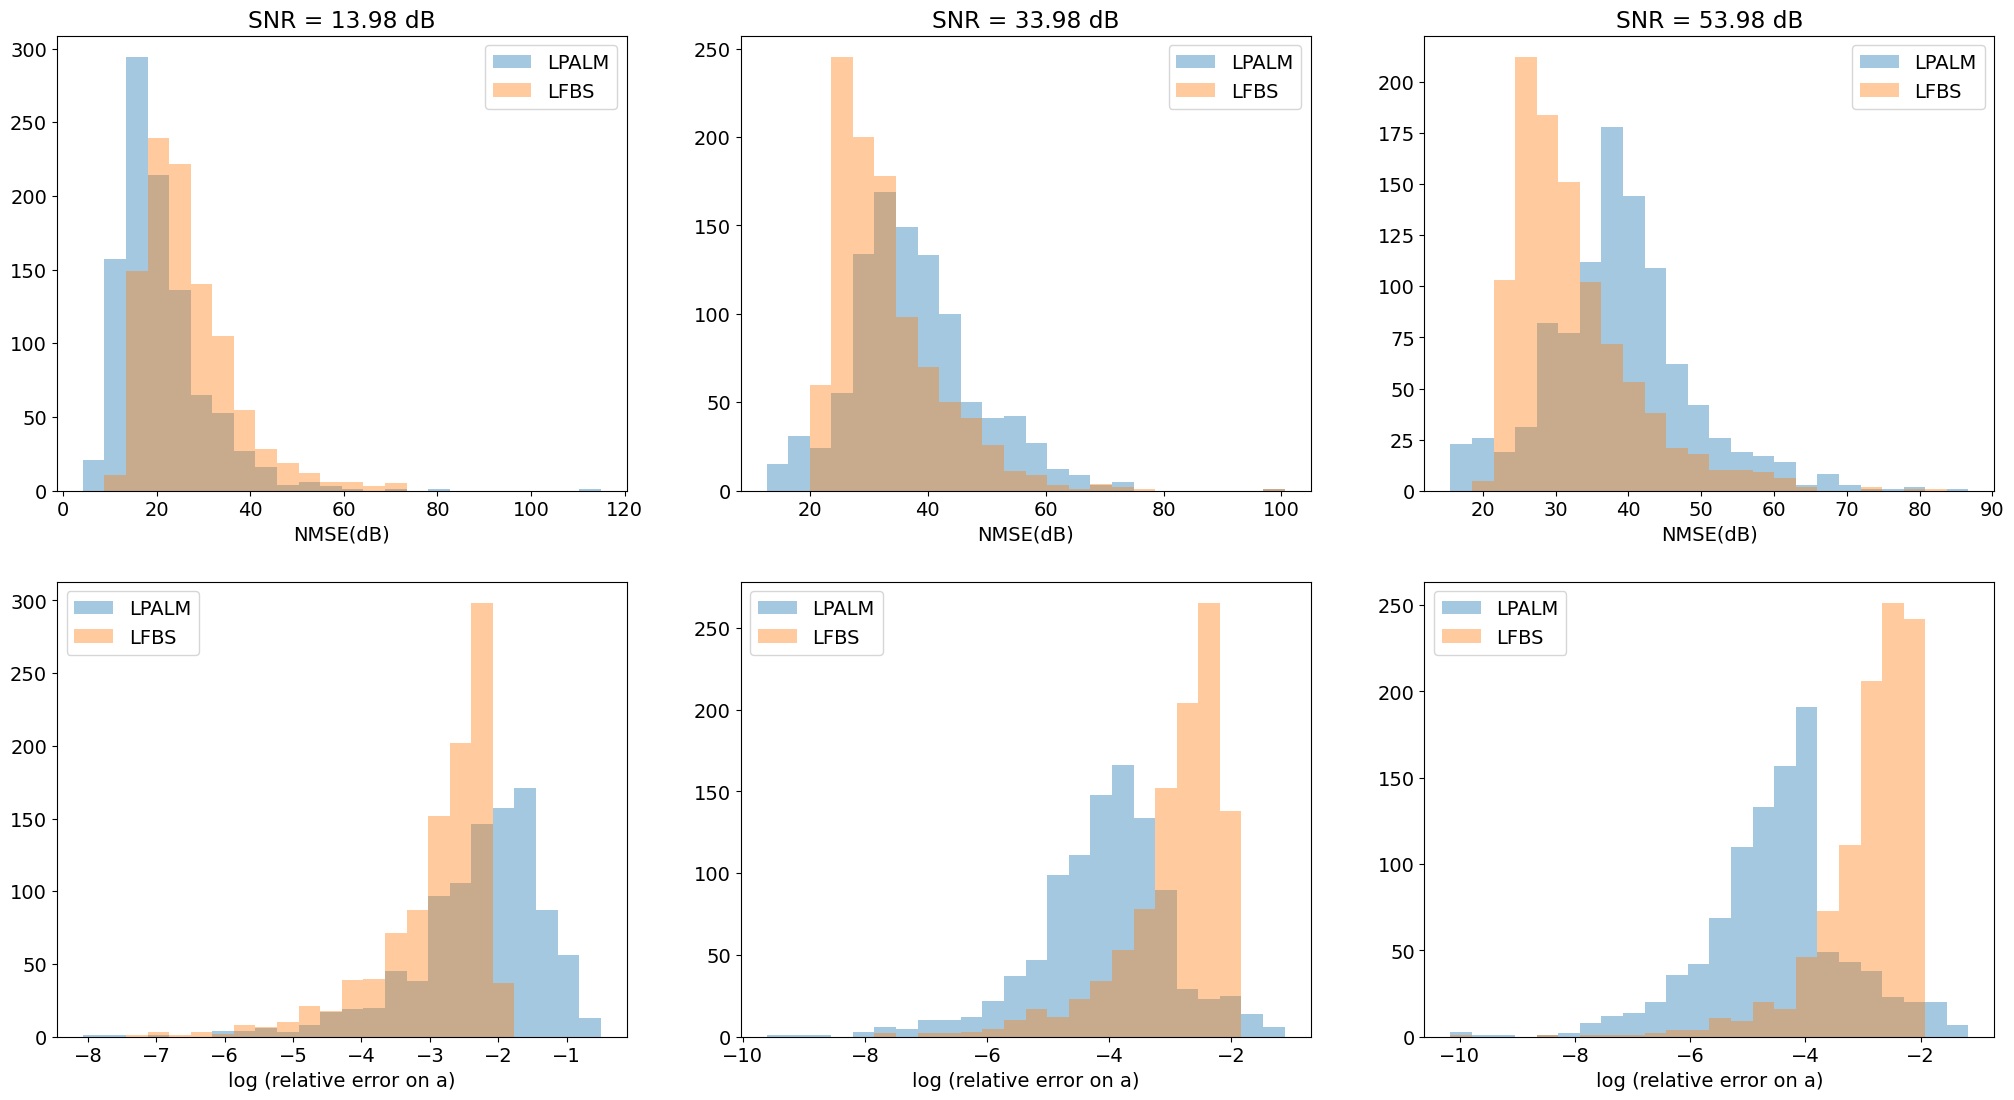

In [44]:
# test model on data with amplitude
t = time.time()
model_LPALM = LPALM.load_model('Models/model_LPALM_L3', device=device)
model_LFBS = LFBS.load_model('Models/model_LFBS_L4_amp', device=device)
model_IAE = cnn.load_model(model_LPALM.iae_fname)
a = 1.1

plt.figure(figsize=(25,13))
j=0
for _noise_level in [1e-1, 1e-2, 1e-3]:
    
    Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
    a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
    a_LPALM = a_LPALM[-1].cpu().detach().numpy()
    x_LPALM = x_LPALM[-1].cpu().detach().numpy()

    nmse_x_LPALM = -10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
    nmse_a_LPALM = np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1))


    x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
    a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))

    nmse_x_LFBS = -10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
    nmse_a_LFBS = np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1))

    plt.subplot(2,3,j+1)
    bins = np.linspace(np.array([nmse_x_LPALM,nmse_x_LFBS]).min(),np.array([nmse_x_LPALM,nmse_x_LFBS]).max(),25)
    plt.hist(nmse_x_LPALM,bins,alpha=0.4,label='LPALM')
    plt.hist(nmse_x_LFBS,bins,alpha=0.4,label='LFBS')
    plt.xlabel('NMSE(dB)')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    plt.subplot(2,3,j+4)
    bins = np.linspace(np.array([nmse_a_LPALM,nmse_a_LFBS]).min(),np.array([nmse_a_LPALM,nmse_a_LFBS]).max(),25)
    plt.hist(nmse_a_LPALM,bins,alpha=0.4,label='LPALM')
    plt.hist(nmse_a_LFBS,bins,alpha=0.4,label='LFBS')
    plt.xlabel('log (relative error on a)')
    plt.legend()
    j+=1
# plt.savefig('./Figures/hist_LPALM_LFBS_amp.png', bbox_inches='tight')
            
print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

### LPALM-LS

In [7]:
import LPALM_LS

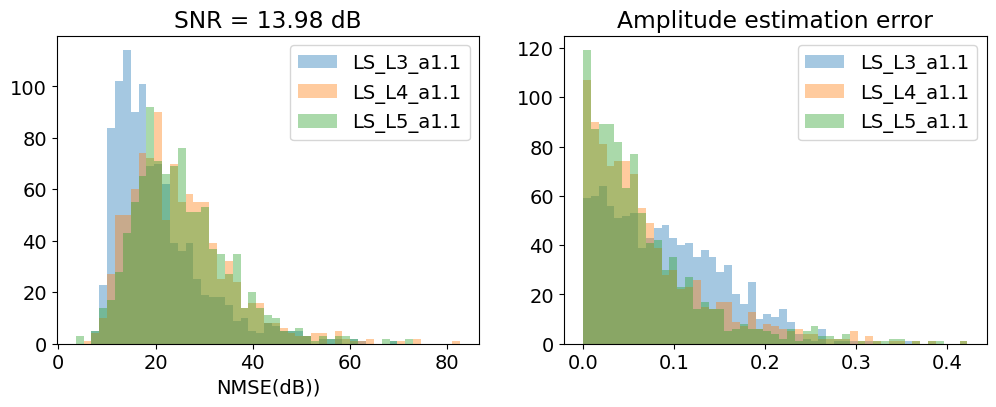

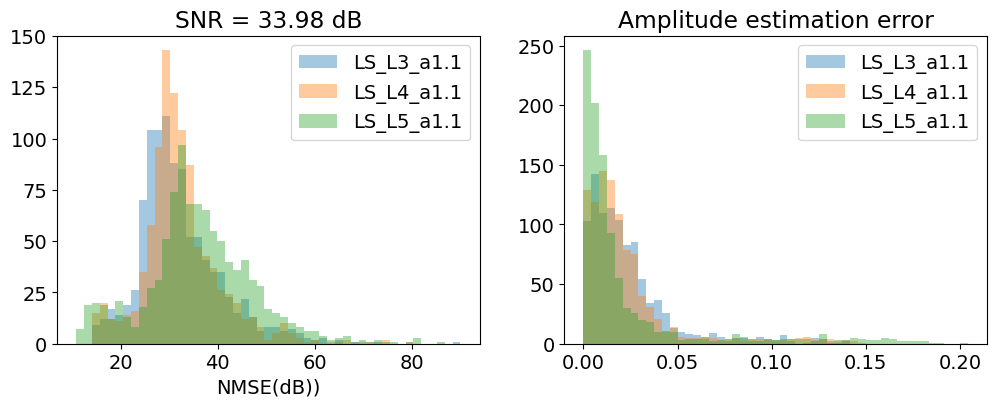

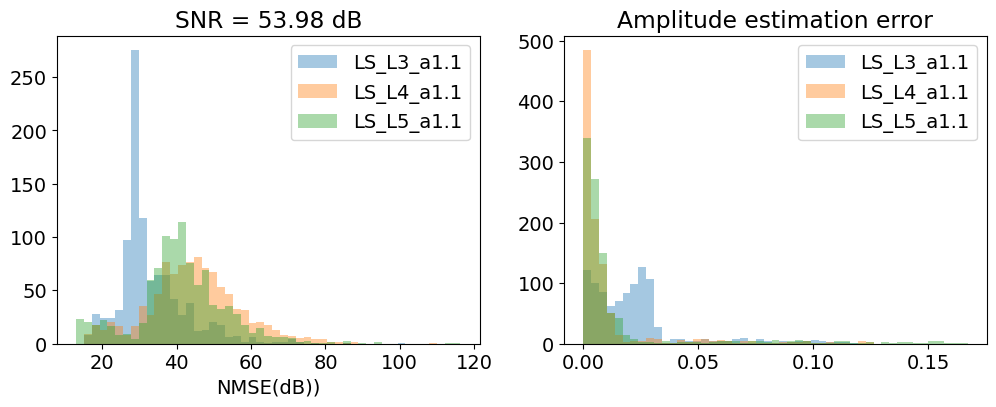

In [9]:
list_fname = ['Models/model_LPALM_LS_L3_a1.1',
              'Models/model_LPALM_LS_L4_a1.1',
              'Models/model_LPALM_LS_L5_a1.1']

for _noise_level in [1e-1, 1e-2, 1e-3]:
    list_nmse=[]
    list_err_A=[]
    for fname in list_fname:
        model_LPALM_LS = LPALM_LS.load_model(fname, device=device)

        model_IAE = cnn.load_model(model_LPALM_LS.iae_fname)

        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level])

        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
        A_pred_LPALM_LS, X_pred_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        A_pred_LPALM_LS = A_pred_LPALM_LS[-1].cpu().detach().numpy()
        X_pred_LPALM_LS = X_pred_LPALM_LS[-1].cpu().detach().numpy()

        nmse_LPALM_LS = -10*np.log10(np.sum((X_pred_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        list_nmse.append(nmse_LPALM_LS)
        list_err_A.append(np.abs(A_pred_LPALM_LS-Atest)/Atest)


    plt.figure(figsize=(12,4))
    plt.subplot(121)
    bins = np.linspace(np.array(list_nmse).min(),np.array(list_nmse).max(),50)
    for i in range(len(list_nmse)):
        plt.hist(list_nmse[i],bins,alpha=0.4,label=list_fname[i][19:])
    plt.xlabel('NMSE(dB))')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    
#     plt.figure()    
    plt.subplot(122)
    bins = np.linspace(np.array(list_err_A).min(),np.array(list_err_A).max(),50)
    for i in range(len(list_err_A)):
        plt.hist(list_err_A[i],bins,alpha=0.4,label=list_fname[i][19:])

    plt.title('Amplitude estimation error')
    plt.legend()


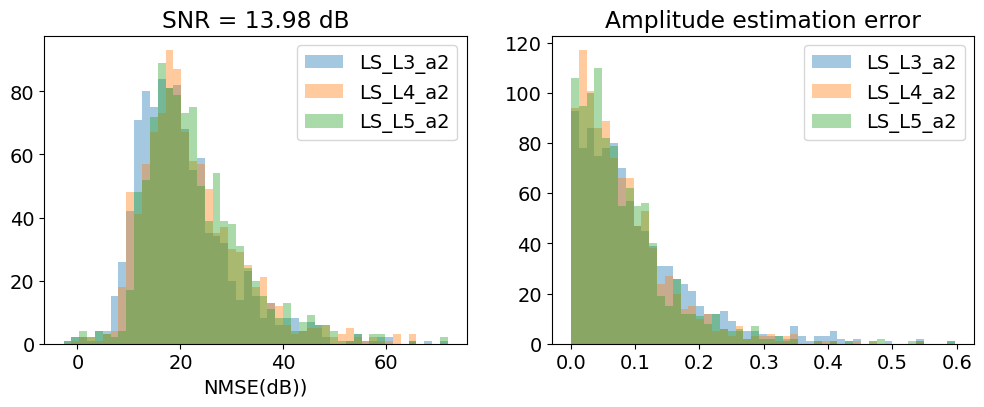

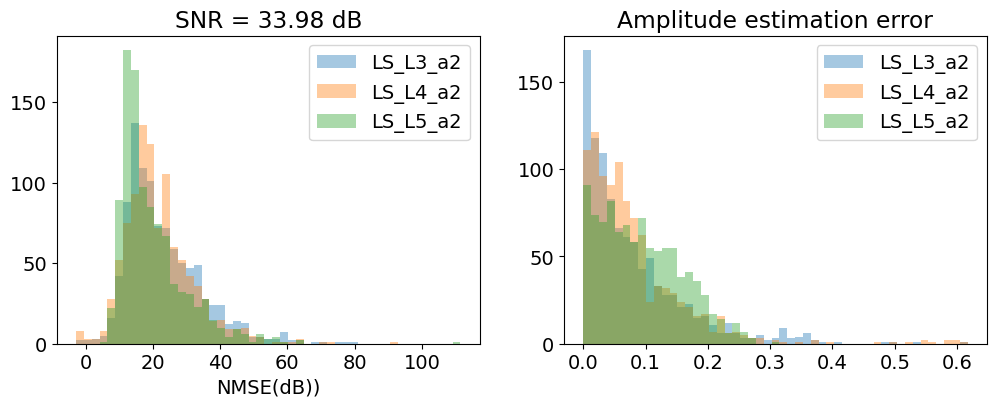

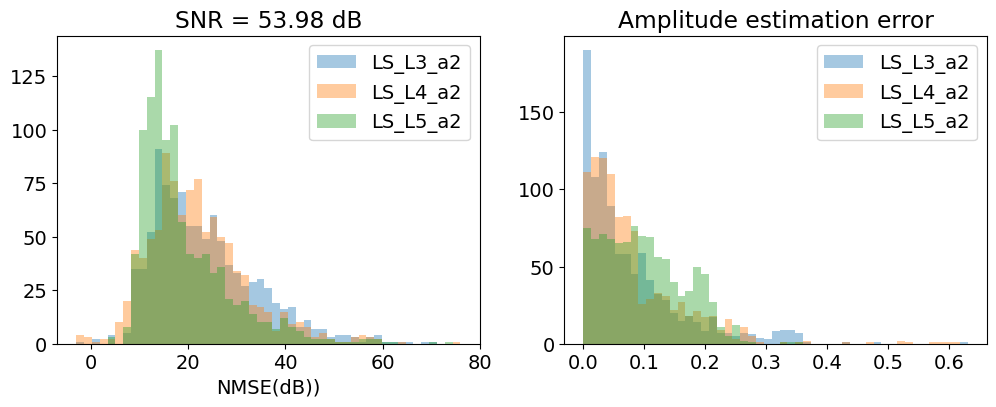

In [4]:
list_fname = ['Models/model_LPALM_LS_L3_a2',
              'Models/model_LPALM_LS_L4_a2',
              'Models/model_LPALM_LS_L5_a2']

for _noise_level in [1e-1, 1e-2, 1e-3]:
    list_nmse=[]
    list_err_A=[]
    for fname in list_fname:
        model_LPALM_LS = LPALM_LS.load_model(fname, device=device)

        model_IAE = cnn.load_model(model_LPALM_LS.iae_fname)

        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level],amplitude_range=2.)

        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
        A_pred_LPALM_LS, X_pred_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        A_pred_LPALM_LS = A_pred_LPALM_LS[-1].cpu().detach().numpy()
        X_pred_LPALM_LS = X_pred_LPALM_LS[-1].cpu().detach().numpy()

        nmse_LPALM_LS = -10*np.log10(np.sum((X_pred_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        list_nmse.append(nmse_LPALM_LS)
        list_err_A.append(np.abs(A_pred_LPALM_LS-Atest)/Atest)


    plt.figure(figsize=(12,4))
    plt.subplot(121)
    bins = np.linspace(np.array(list_nmse).min(),np.array(list_nmse).max(),50)
    for i in range(len(list_nmse)):
        plt.hist(list_nmse[i],bins,alpha=0.4,label=list_fname[i][19:])
    plt.xlabel('NMSE(dB))')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    
#     plt.figure()    
    plt.subplot(122)
    bins = np.linspace(np.array(list_err_A).min(),np.array(list_err_A).max(),50)
    for i in range(len(list_err_A)):
        plt.hist(list_err_A[i],bins,alpha=0.4,label=list_fname[i][19:])

    plt.title('Amplitude estimation error')
    plt.legend()


Computation time with cuda: 2.930 s


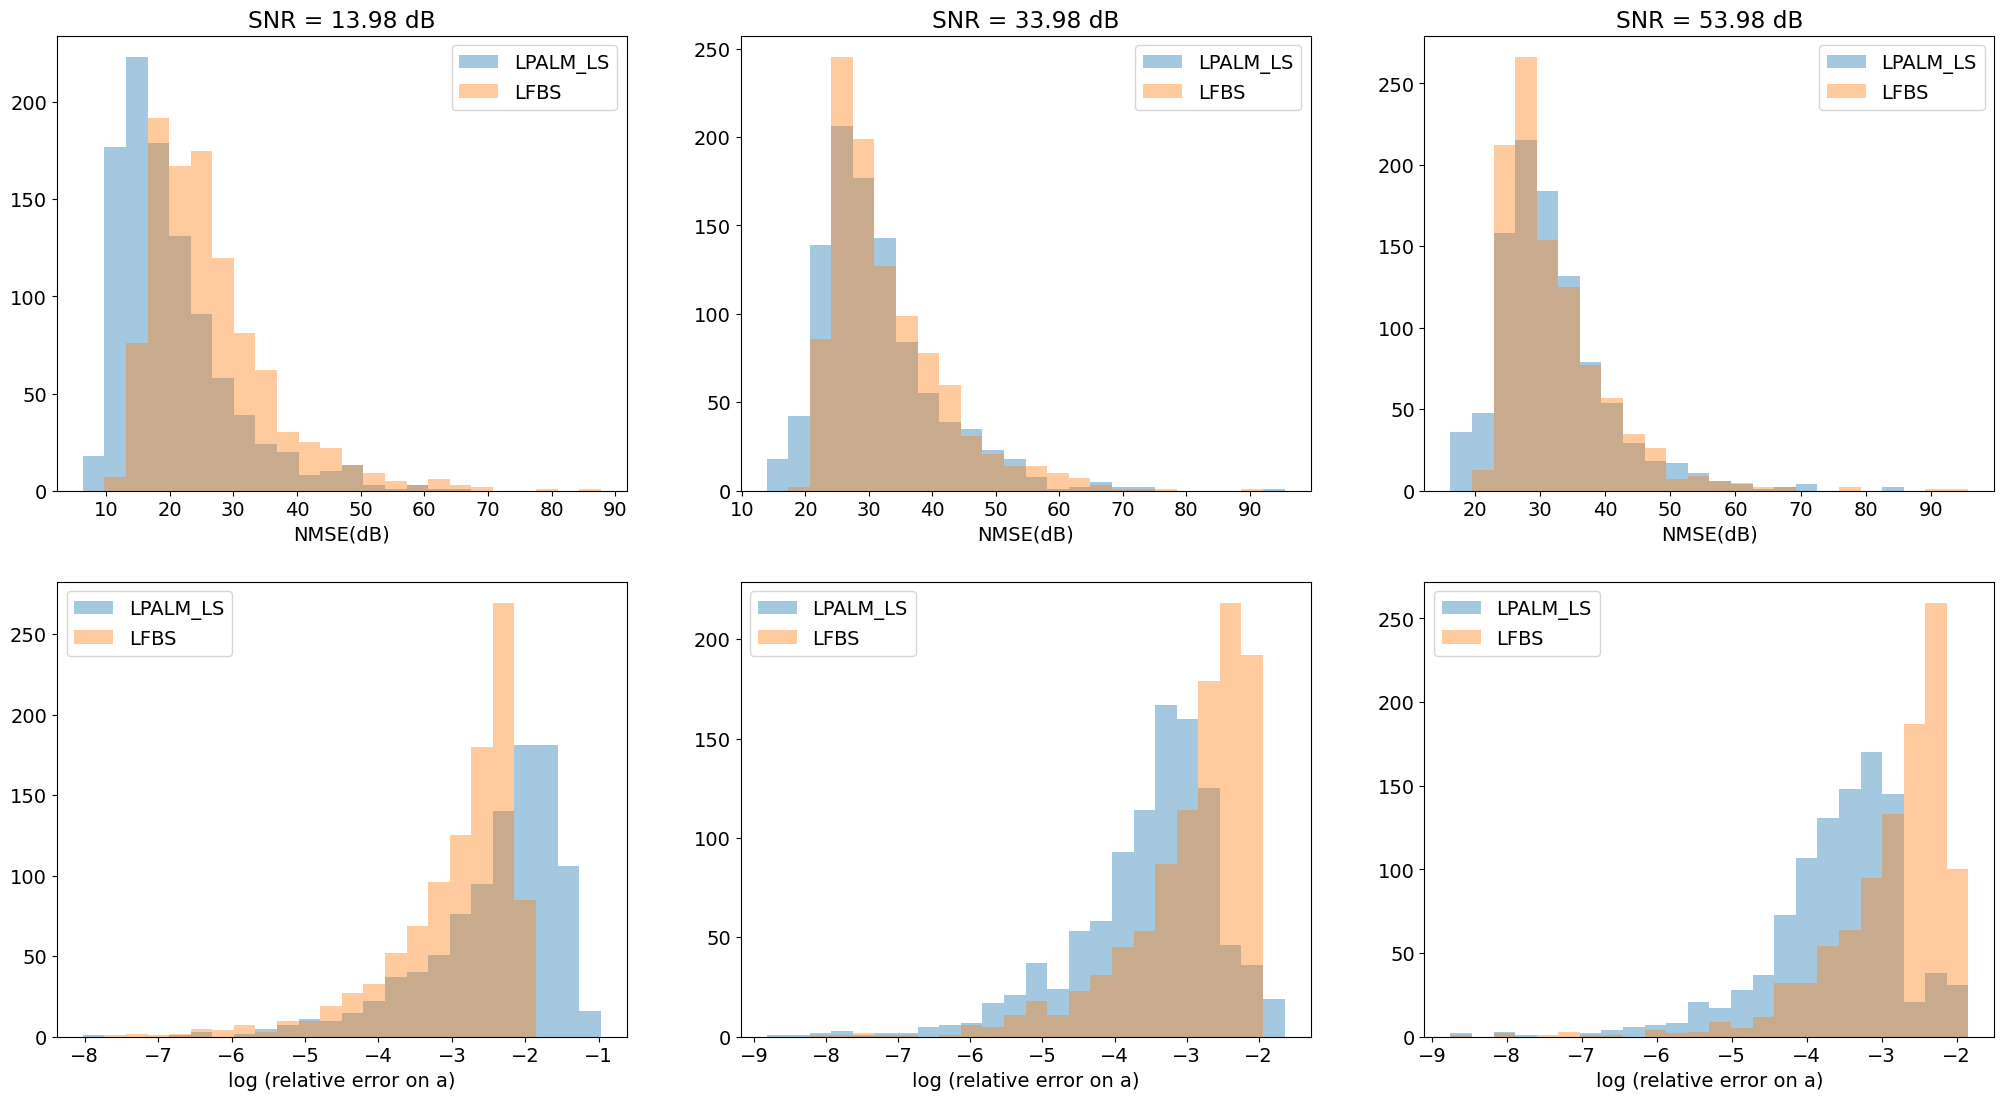

In [12]:
# test model on data with amplitude
t = time.time()
model_LPALM_LS = LPALM_LS.load_model('Models/model_LPALM_LS_L3_a1.1', device=device)
model_LFBS = LFBS.load_model('Models/model_LFBS_L4_amp', device=device)
model_IAE = cnn.load_model(model_LPALM_LS.iae_fname)
a = 1.1

plt.figure(figsize=(25,13))
j=0
for _noise_level in [1e-1, 1e-2, 1e-3]:
    
    Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
    a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
    a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
    x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()

    nmse_x_LPALM_LS = -10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
    nmse_a_LPALM_LS = np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1))


    x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
    a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))

    nmse_x_LFBS = -10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
    nmse_a_LFBS = np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1))

    plt.subplot(2,3,j+1)
    bins = np.linspace(np.array([nmse_x_LPALM_LS,nmse_x_LFBS]).min(),np.array([nmse_x_LPALM_LS,nmse_x_LFBS]).max(),25)
    plt.hist(nmse_x_LPALM_LS,bins,alpha=0.4,label='LPALM_LS')
    plt.hist(nmse_x_LFBS,bins,alpha=0.4,label='LFBS')
    plt.xlabel('NMSE(dB)')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    plt.subplot(2,3,j+4)
    bins = np.linspace(np.array([nmse_a_LPALM_LS,nmse_a_LFBS]).min(),np.array([nmse_a_LPALM_LS,nmse_a_LFBS]).max(),25)
    plt.hist(nmse_a_LPALM_LS,bins,alpha=0.4,label='LPALM_LS')
    plt.hist(nmse_a_LFBS,bins,alpha=0.4,label='LFBS')
    plt.xlabel('log (relative error on a)')
    plt.legend()
    j+=1
plt.savefig('./Figures/hist_LPALM_LS_LFBS_amp.png', bbox_inches='tight')
            
print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

In [75]:
# test model on data with amplitude
t = time.time()
model_LPALM = LPALM.load_model('Models/model_LPALM_L3_a2', device=device)
model_LPALM_LS = LPALM_LS.load_model('Models/model_LPALM_LS_L3_a2', device=device)
model_IAE = cnn.load_model(model_LPALM_LS.iae_fname)
a = 2.

plt.figure(figsize=(25,13))
j=0
for _noise_level in [1e-1, 1e-2, 1e-3]:
    
    Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)
    a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
    a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
    x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()

    nmse_x_LPALM_LS = -10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
    nmse_a_LPALM_LS = np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1))

    a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
    a_LPALM = a_LPALM[-1].cpu().detach().numpy()
    x_LPALM = x_LPALM[-1].cpu().detach().numpy()

    nmse_x_LPALM = -10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
    nmse_a_LPALM = np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1))

    plt.subplot(2,3,j+1)
    bins = np.linspace(np.array([nmse_x_LPALM_LS,nmse_x_LPALM]).min(),np.array([nmse_x_LPALM_LS,nmse_x_LPALM]).max(),25)
    plt.hist(nmse_x_LPALM_LS,bins,alpha=0.4,label='LPALM_LS')
    plt.hist(nmse_x_LPALM,bins,alpha=0.4,label='LPALM')
    plt.xlabel('NMSE(dB)')
    plt.title('SNR = %.2f dB' % (20*np.log10(0.5/_noise_level)))
    plt.legend()
    plt.subplot(2,3,j+4)
    bins = np.linspace(np.array([nmse_a_LPALM_LS,nmse_a_LPALM]).min(),np.array([nmse_a_LPALM_LS,nmse_a_LPALM]).max(),25)
    plt.hist(nmse_a_LPALM_LS,bins,alpha=0.4,label='LPALM_LS')
    plt.hist(nmse_a_LPALM,bins,alpha=0.4,label='LPALM')
    plt.xlabel('log (relative error on a)')
    plt.legend()
    j+=1
# plt.savefig('./Figures/hist_LPALM_LS_a2.png', bbox_inches='tight')
            
print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

FileNotFoundError: [Errno 2] No such file or directory: 'Models/model_LPALM_L3.pth'

In [17]:
noise_amp = np.abs(Ytrain-np.einsum('ik,ijk->ijk',Atrain, Xtrain)).max(1)

In [25]:
np.sqrt(noise_amp.var())

0.07162300652740548

In [24]:
noise_amp.max(),noise_amp.min()

(0.2809189297412026, 0.003189922312335919)

In [20]:
noise_amp.mean()

0.06335574942247027

In [37]:
_noise_level=1e-2
Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=1.)

noise_amp = np.abs(Ytest-np.einsum('ik,ijk->ijk',Atest, Xtest)).max(1)
snr = np.einsum('ij,ij->i',noise_amp, 1./Atest)
# print(np.sqrt(noise_amp.var()))
# print(noise_amp.max(),noise_amp.min())
# print(noise_amp.mean())
print(snr.mean())
print(snr.max(), snr.min(), np.sqrt(snr.var()))

0.031751105053072166
0.0498245108530635 0.02394777227967447 0.0035828569514103157


In [45]:
_noise_level=1e-3
Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=10.)

noise_amp = np.abs(Ytest-np.einsum('ik,ijk->ijk',Atest, Xtest)).max(1)
snr = np.einsum('ij,ij->i',noise_amp, 1./Atest)
# print(np.sqrt(noise_amp.var()))
# print(noise_amp.max(),noise_amp.min())
# print(noise_amp.mean())
print(snr.mean())
print(snr.max(), snr.min(), np.sqrt(snr.var()))

0.003194395384434513
0.005189975940140667 0.002397777965088124 0.0003617622564735992


In [58]:
-20*np.log10(0.2397777965088124)

12.403820703321673

### Comparison LFBS_a1, LFBS_a2, LPALM_a2, LPALM_LS_a2

In [9]:
# test model on data with amplitude
t = time.time()
model_LFBS = LFBS.load_model('Models/models0523/model_LFBS_L4_a1', device=device)
model_LFBS_amp = LFBS.load_model('Models/models0523/model_LFBS_L4_a2', device=device)
model_LPALM = LPALM.load_model('Models/models0523/model_LPALM_L3_a2', device=device)
model_LPALM_LS = LPALM_LS.load_model('Models/models0523/model_LPALM_LS_L4_a2', device=device)
model_IAE = cnn.load_model(model_LPALM_LS.iae_fname)

Computation time with cuda: 5.482 s


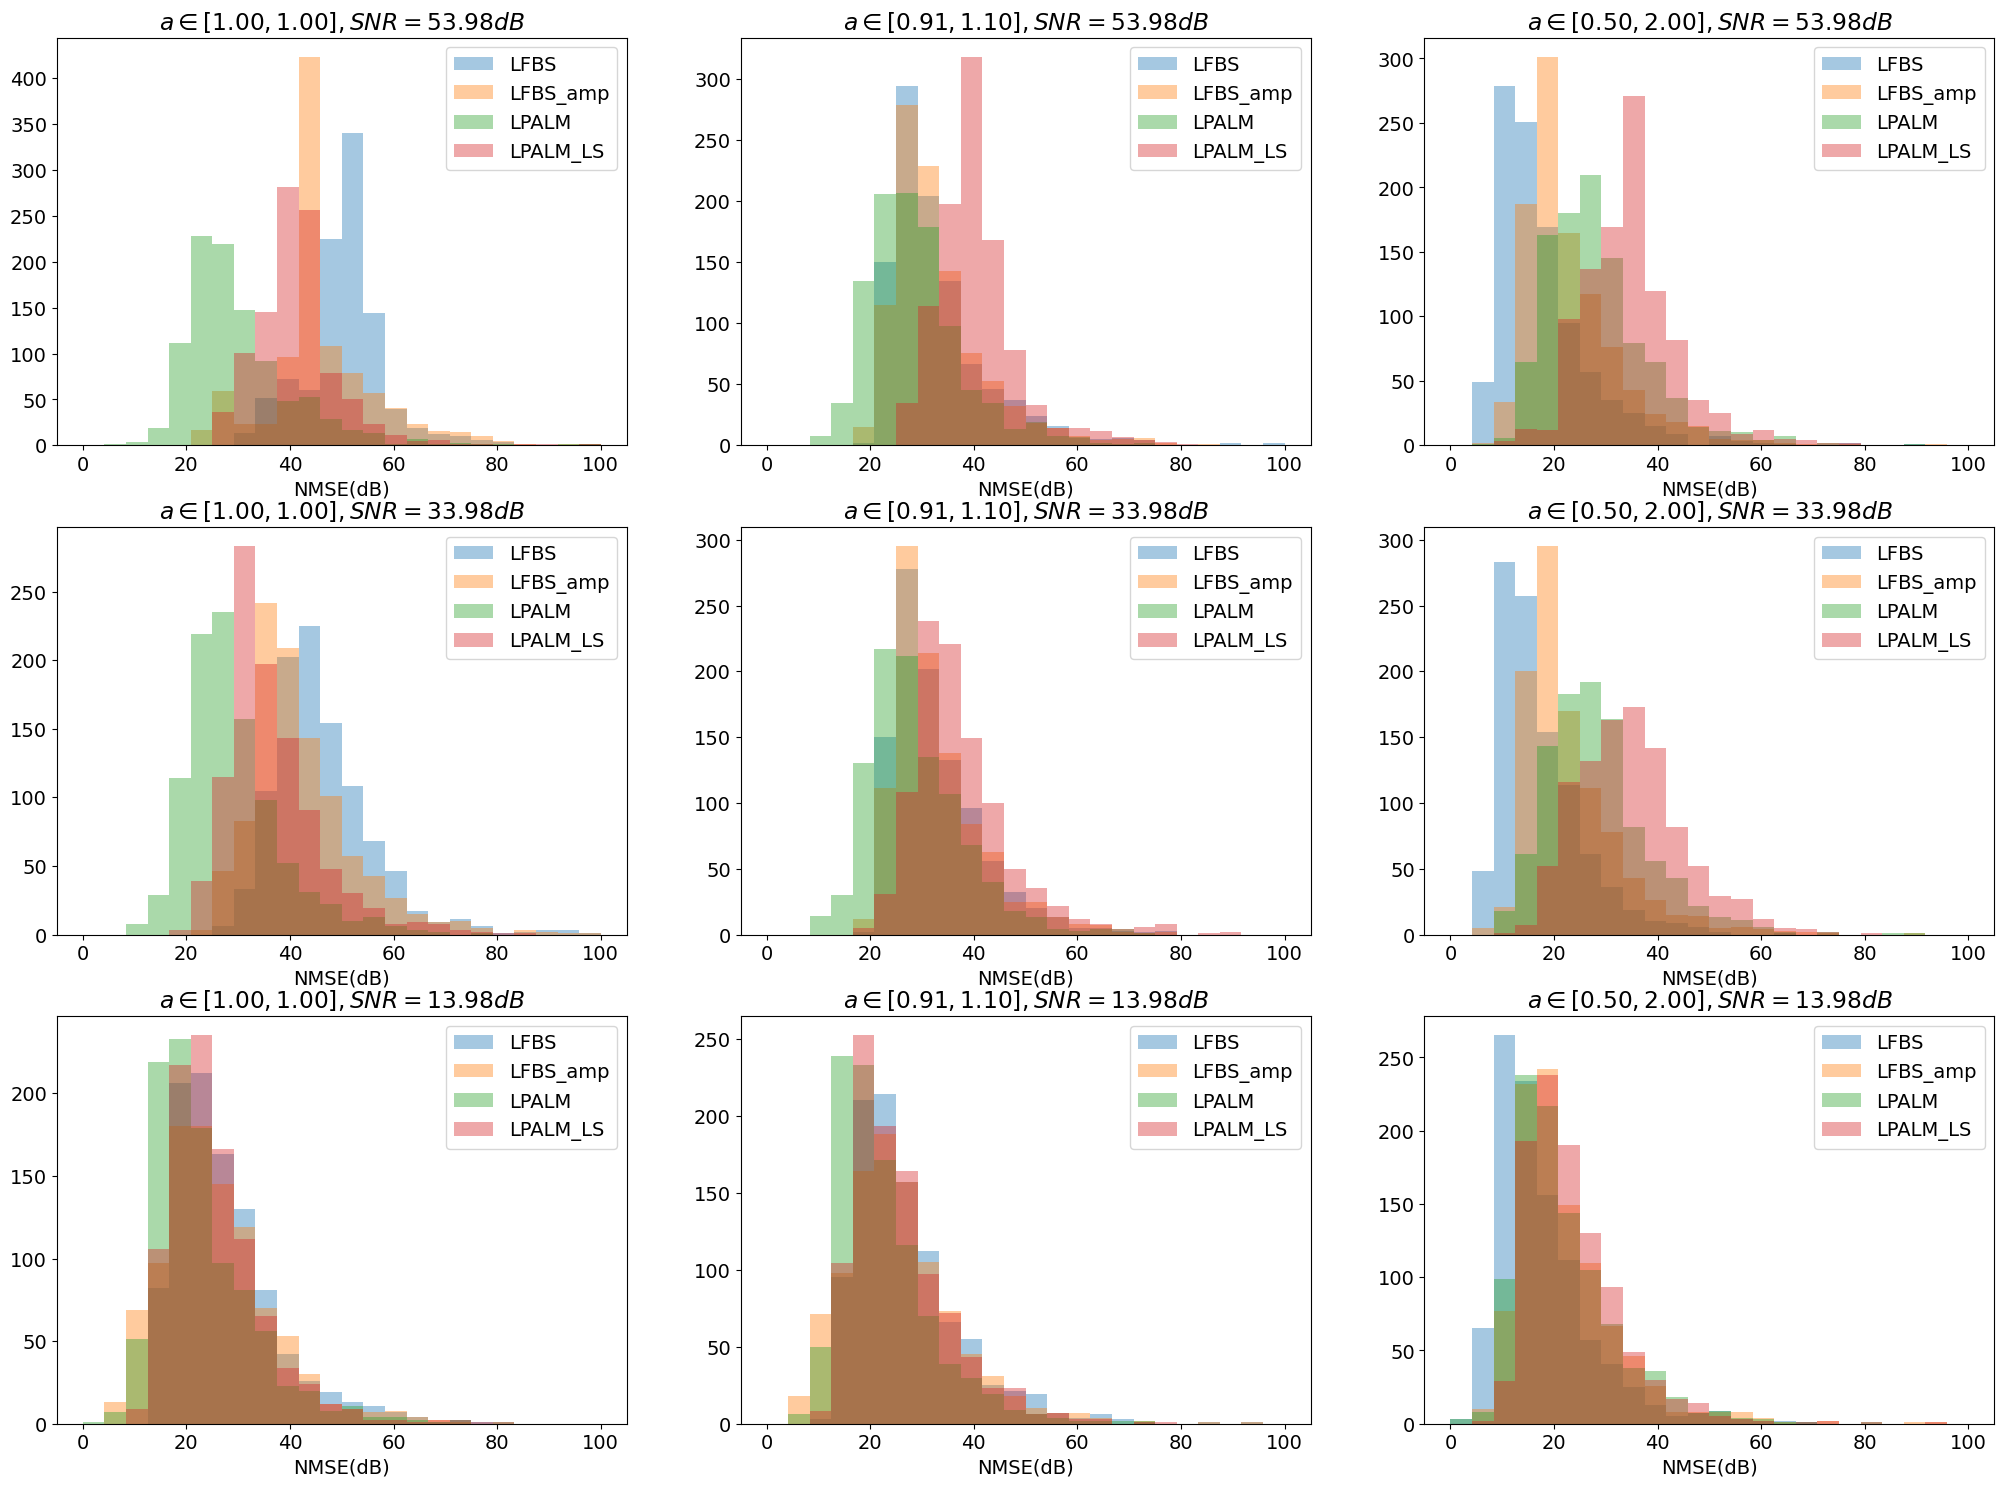

In [10]:
t = time.time()
plt.figure(figsize=(25,18))
j=0
for _noise_level in [1e-3, 1e-2,1e-1]:
    i=0
    for a in [1., 1.1, 2.]:
        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

        x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))
        nmse_x_LFBS = -10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS = np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        x_LFBS_amp = model_LFBS_amp.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS_amp = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS_amp.max(1))
        nmse_x_LFBS_amp = -10*np.log10(np.sum((x_LFBS_amp-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS_amp = np.log10(np.sum((a_LFBS_amp-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
        x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()
        nmse_x_LPALM_LS = -10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM_LS = np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM = a_LPALM[-1].cpu().detach().numpy()
        x_LPALM = x_LPALM[-1].cpu().detach().numpy()
        nmse_x_LPALM = -10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM = np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        plt.subplot(3,3,3*j+i+1)
#         bins = np.linspace(np.array([nmse_x_LFBS,nmse_x_LFBS_amp,nmse_x_LPALM,nmse_x_LPALM_LS]).min(),np.array([nmse_x_LFBS,nmse_x_LFBS_amp,nmse_x_LPALM,nmse_x_LPALM_LS]).max(),25)
        bins = np.linspace(0, 100, 25)    
        plt.hist(nmse_x_LFBS,bins,alpha=0.4,label='LFBS')
        plt.hist(nmse_x_LFBS_amp,bins,alpha=0.4,label='LFBS_amp')
        plt.hist(nmse_x_LPALM,bins,alpha=0.4,label='LPALM')
        plt.hist(nmse_x_LPALM_LS,bins,alpha=0.4,label='LPALM_LS')
        plt.title('$a \in [%.2f, %.2f], SNR = %.2f dB$'%(1/a,a,20*np.log10(0.5/_noise_level)))
        plt.xlabel('NMSE(dB)')
        plt.legend()
        i += 1
    j+=1
# plt.savefig('./Figures/hist_compare_models.png', bbox_inches='tight')
            
print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

Computation time with cuda: 5.168 s


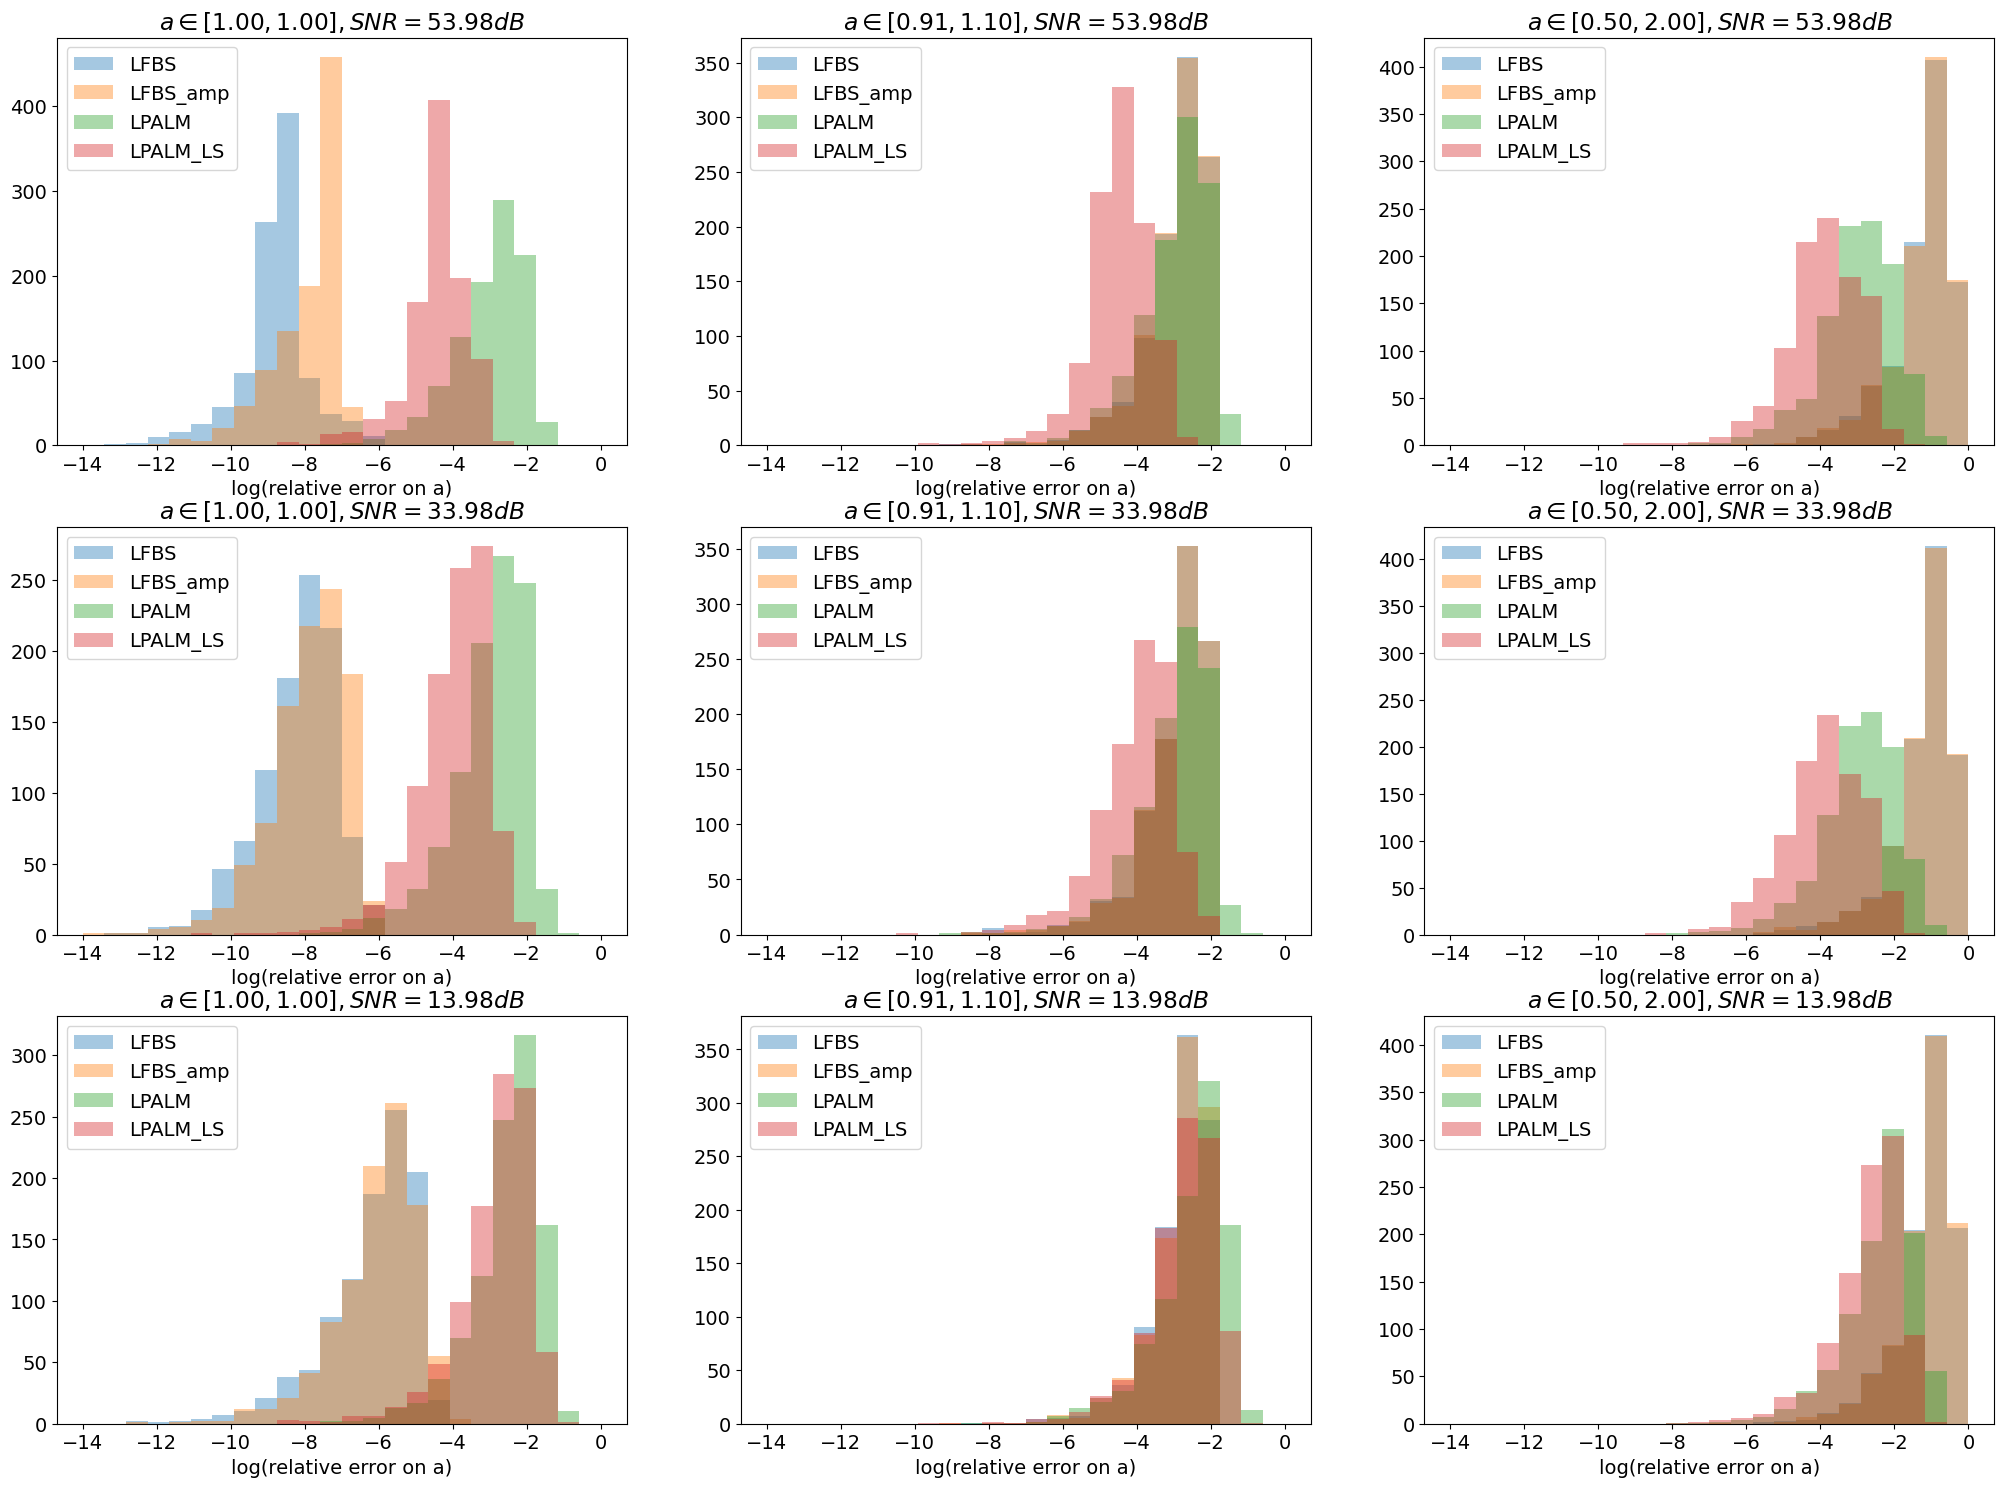

In [11]:
t = time.time()
plt.figure(figsize=(25,18))
j=0
for _noise_level in [1e-3, 1e-2,1e-1]:
    i=0
    for a in [1., 1.1, 2.]:
        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

        x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))
        nmse_x_LFBS = -10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS = np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        x_LFBS_amp = model_LFBS_amp.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS_amp = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS_amp.max(1))
        nmse_x_LFBS_amp = -10*np.log10(np.sum((x_LFBS_amp-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS_amp = np.log10(np.sum((a_LFBS_amp-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
        x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()
        nmse_x_LPALM_LS = -10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM_LS = np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM = a_LPALM[-1].cpu().detach().numpy()
        x_LPALM = x_LPALM[-1].cpu().detach().numpy()
        nmse_x_LPALM = -10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM = np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        plt.subplot(3,3,3*j+i+1)
#         bins = np.linspace(np.array([nmse_a_LFBS,nmse_a_LFBS_amp,nmse_a_LPALM,nmse_a_LPALM_LS]).min(),np.array([nmse_a_LFBS,nmse_a_LFBS_amp,nmse_a_LPALM,nmse_a_LPALM_LS]).max(),25)
        bins = np.linspace(-14, 0, 25)    
        plt.hist(nmse_a_LFBS,bins,alpha=0.4,label='LFBS')
        plt.hist(nmse_a_LFBS_amp,bins,alpha=0.4,label='LFBS_amp')
        plt.hist(nmse_a_LPALM,bins,alpha=0.4,label='LPALM')
        plt.hist(nmse_a_LPALM_LS,bins,alpha=0.4,label='LPALM_LS')
        plt.xlabel('log(relative error on a)')
        plt.title('$a \in [%.2f, %.2f], SNR = %.2f dB$'%(1/a,a,20*np.log10(0.5/_noise_level)))
        plt.legend()
        i += 1
    j+=1
# plt.savefig('./Figures/hist_compare_models_a.png', bbox_inches='tight')
            
print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

In [12]:
# def evaluate_LFBS(model, noise_level, amplitude=1., nb_samples=1000):
#     Ytest, Atest, Xtest = generate_dataset(model_IAE, nb_samples, noise_level = [noise_level, noise_level], amplitude_range=amplitude)
#     dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

#     x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
#     a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))
#     nmse_x = -10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
#     nmse_a = np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1))
    
#     return nmse_x, nmse_a

# def evaluate_LPALM(model, noise_level, amplitude, nb_samples):
#     Ytest, Atest, Xtest = generate_dataset(model_IAE, nb_samples, noise_level = [noise_level, noise_level], amplitude_range=amplitude)
#     dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

#     a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
#     a_LPALM = a_LPALM[-1].cpu().detach().numpy()
#     x_LPALM = x_LPALM[-1].cpu().detach().numpy()
#     nmse_x = -10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
#     nmse_a = np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1))
    
#     return nmse_x, nmse_a

Computation time with cuda: 5.895 s


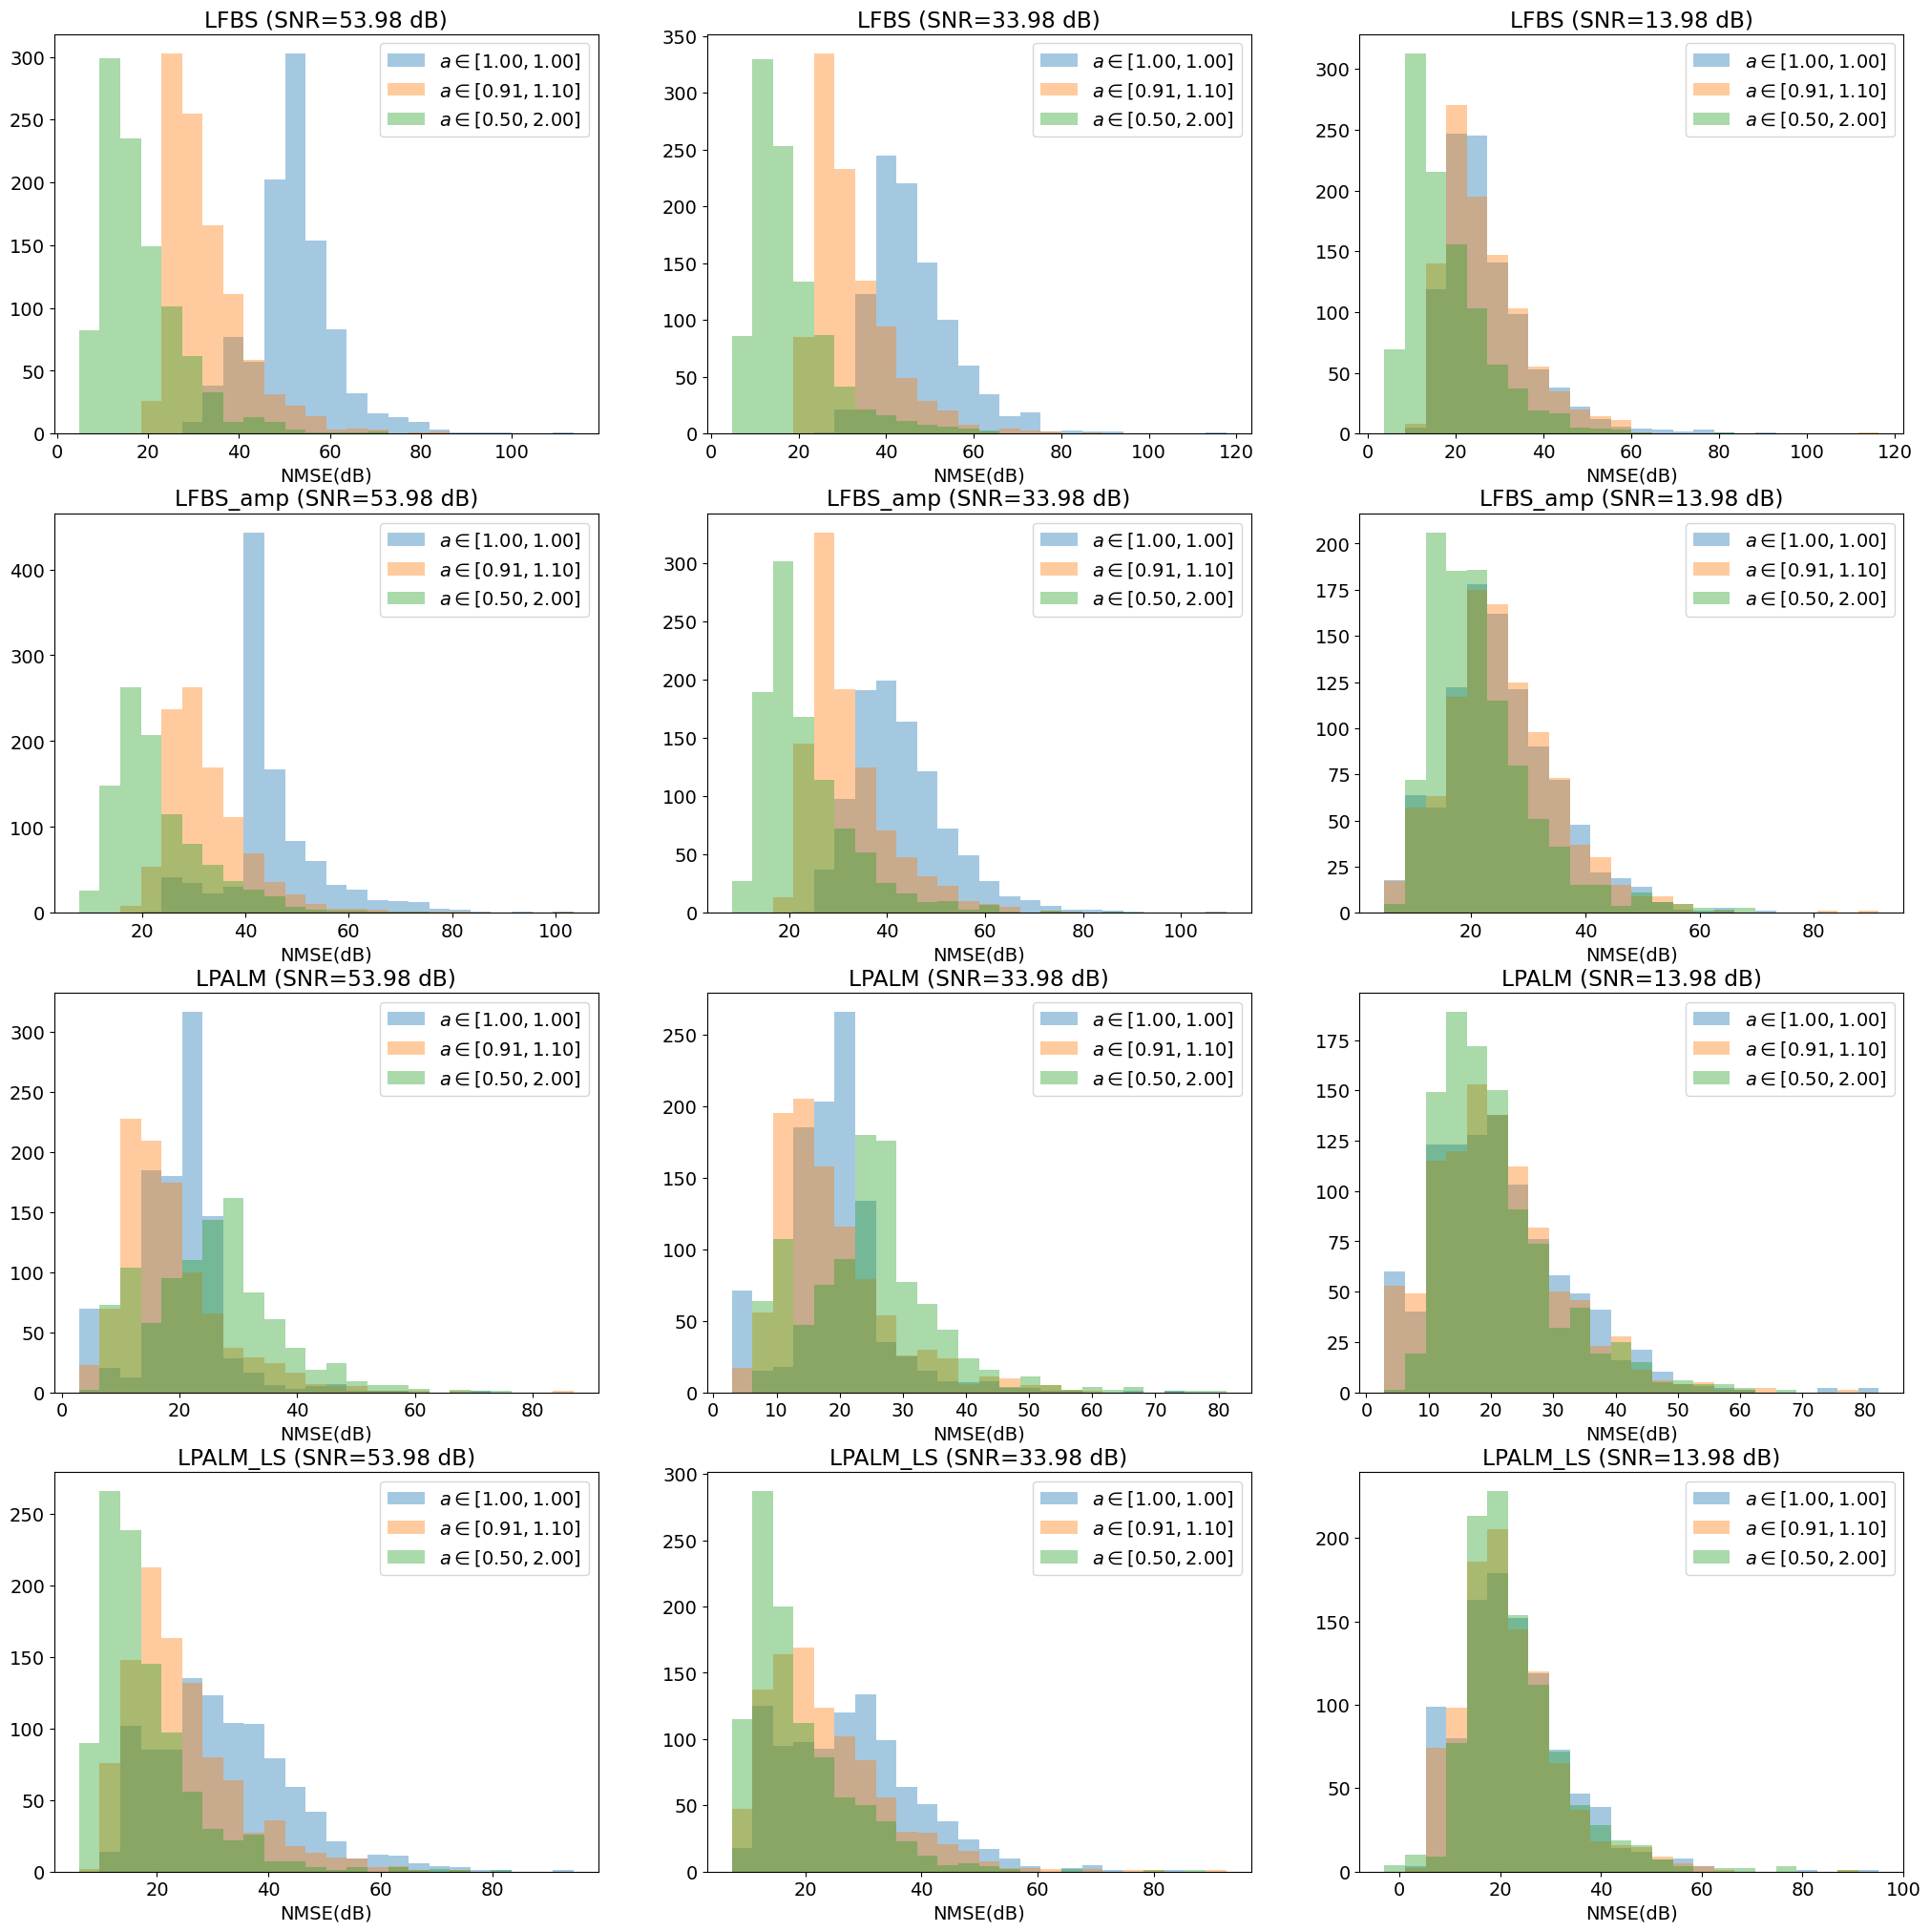

In [54]:
t = time.time()
plt.figure(figsize=(25,25))
i=0
for _noise_level in [1e-3,1e-2,1e-1]:

    nmse_x_LFBS=[]
    nmse_a_LFBS=[]
    nmse_x_LFBS_amp=[]
    nmse_a_LFBS_amp=[]
    nmse_x_LPALM_LS=[]
    nmse_a_LPALM_LS=[]
    nmse_x_LPALM=[]
    nmse_a_LPALM=[]
    for a in [1., 1.1, 2.]:
        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

        x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))
        nmse_x_LFBS.append(-10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LFBS.append(np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

        x_LFBS_amp = model_LFBS_amp.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS_amp = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS_amp.max(1))
        nmse_x_LFBS_amp.append(-10*np.log10(np.sum((x_LFBS_amp-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LFBS_amp.append(np.log10(np.sum((a_LFBS_amp-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

        a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
        x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()
        nmse_x_LPALM_LS.append(-10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LPALM_LS.append(np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

        a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM = a_LPALM[-1].cpu().detach().numpy()
        x_LPALM = x_LPALM[-1].cpu().detach().numpy()
        nmse_x_LPALM.append(-10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LPALM.append(np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

    j=0
    for a in [1., 1.1, 2.]:
        plt.subplot(4,3,i+1)
        bins = np.linspace(np.array(nmse_x_LFBS).min(),np.array(nmse_x_LFBS).max(),25)
        plt.hist(nmse_x_LFBS[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LFBS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+4)
        bins = np.linspace(np.array(nmse_x_LFBS_amp).min(),np.array(nmse_x_LFBS_amp).max(),25)
        plt.hist(nmse_x_LFBS_amp[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LFBS_amp (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+7)
        bins = np.linspace(np.array(nmse_x_LPALM).min(),np.array(nmse_x_LPALM).max(),25)
        plt.hist(nmse_x_LPALM[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LPALM (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()
        plt.subplot(4,3,i+10)
        bins = np.linspace(np.array(nmse_x_LPALM_LS).min(),np.array(nmse_x_LPALM_LS).max(),25)
        plt.hist(nmse_x_LPALM_LS[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LPALM_LS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()
        j+=1
    i+=1
# plt.savefig('./Figures/hist_robust_models.png', bbox_inches='tight')

print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

Computation time with cuda: 6.000 s


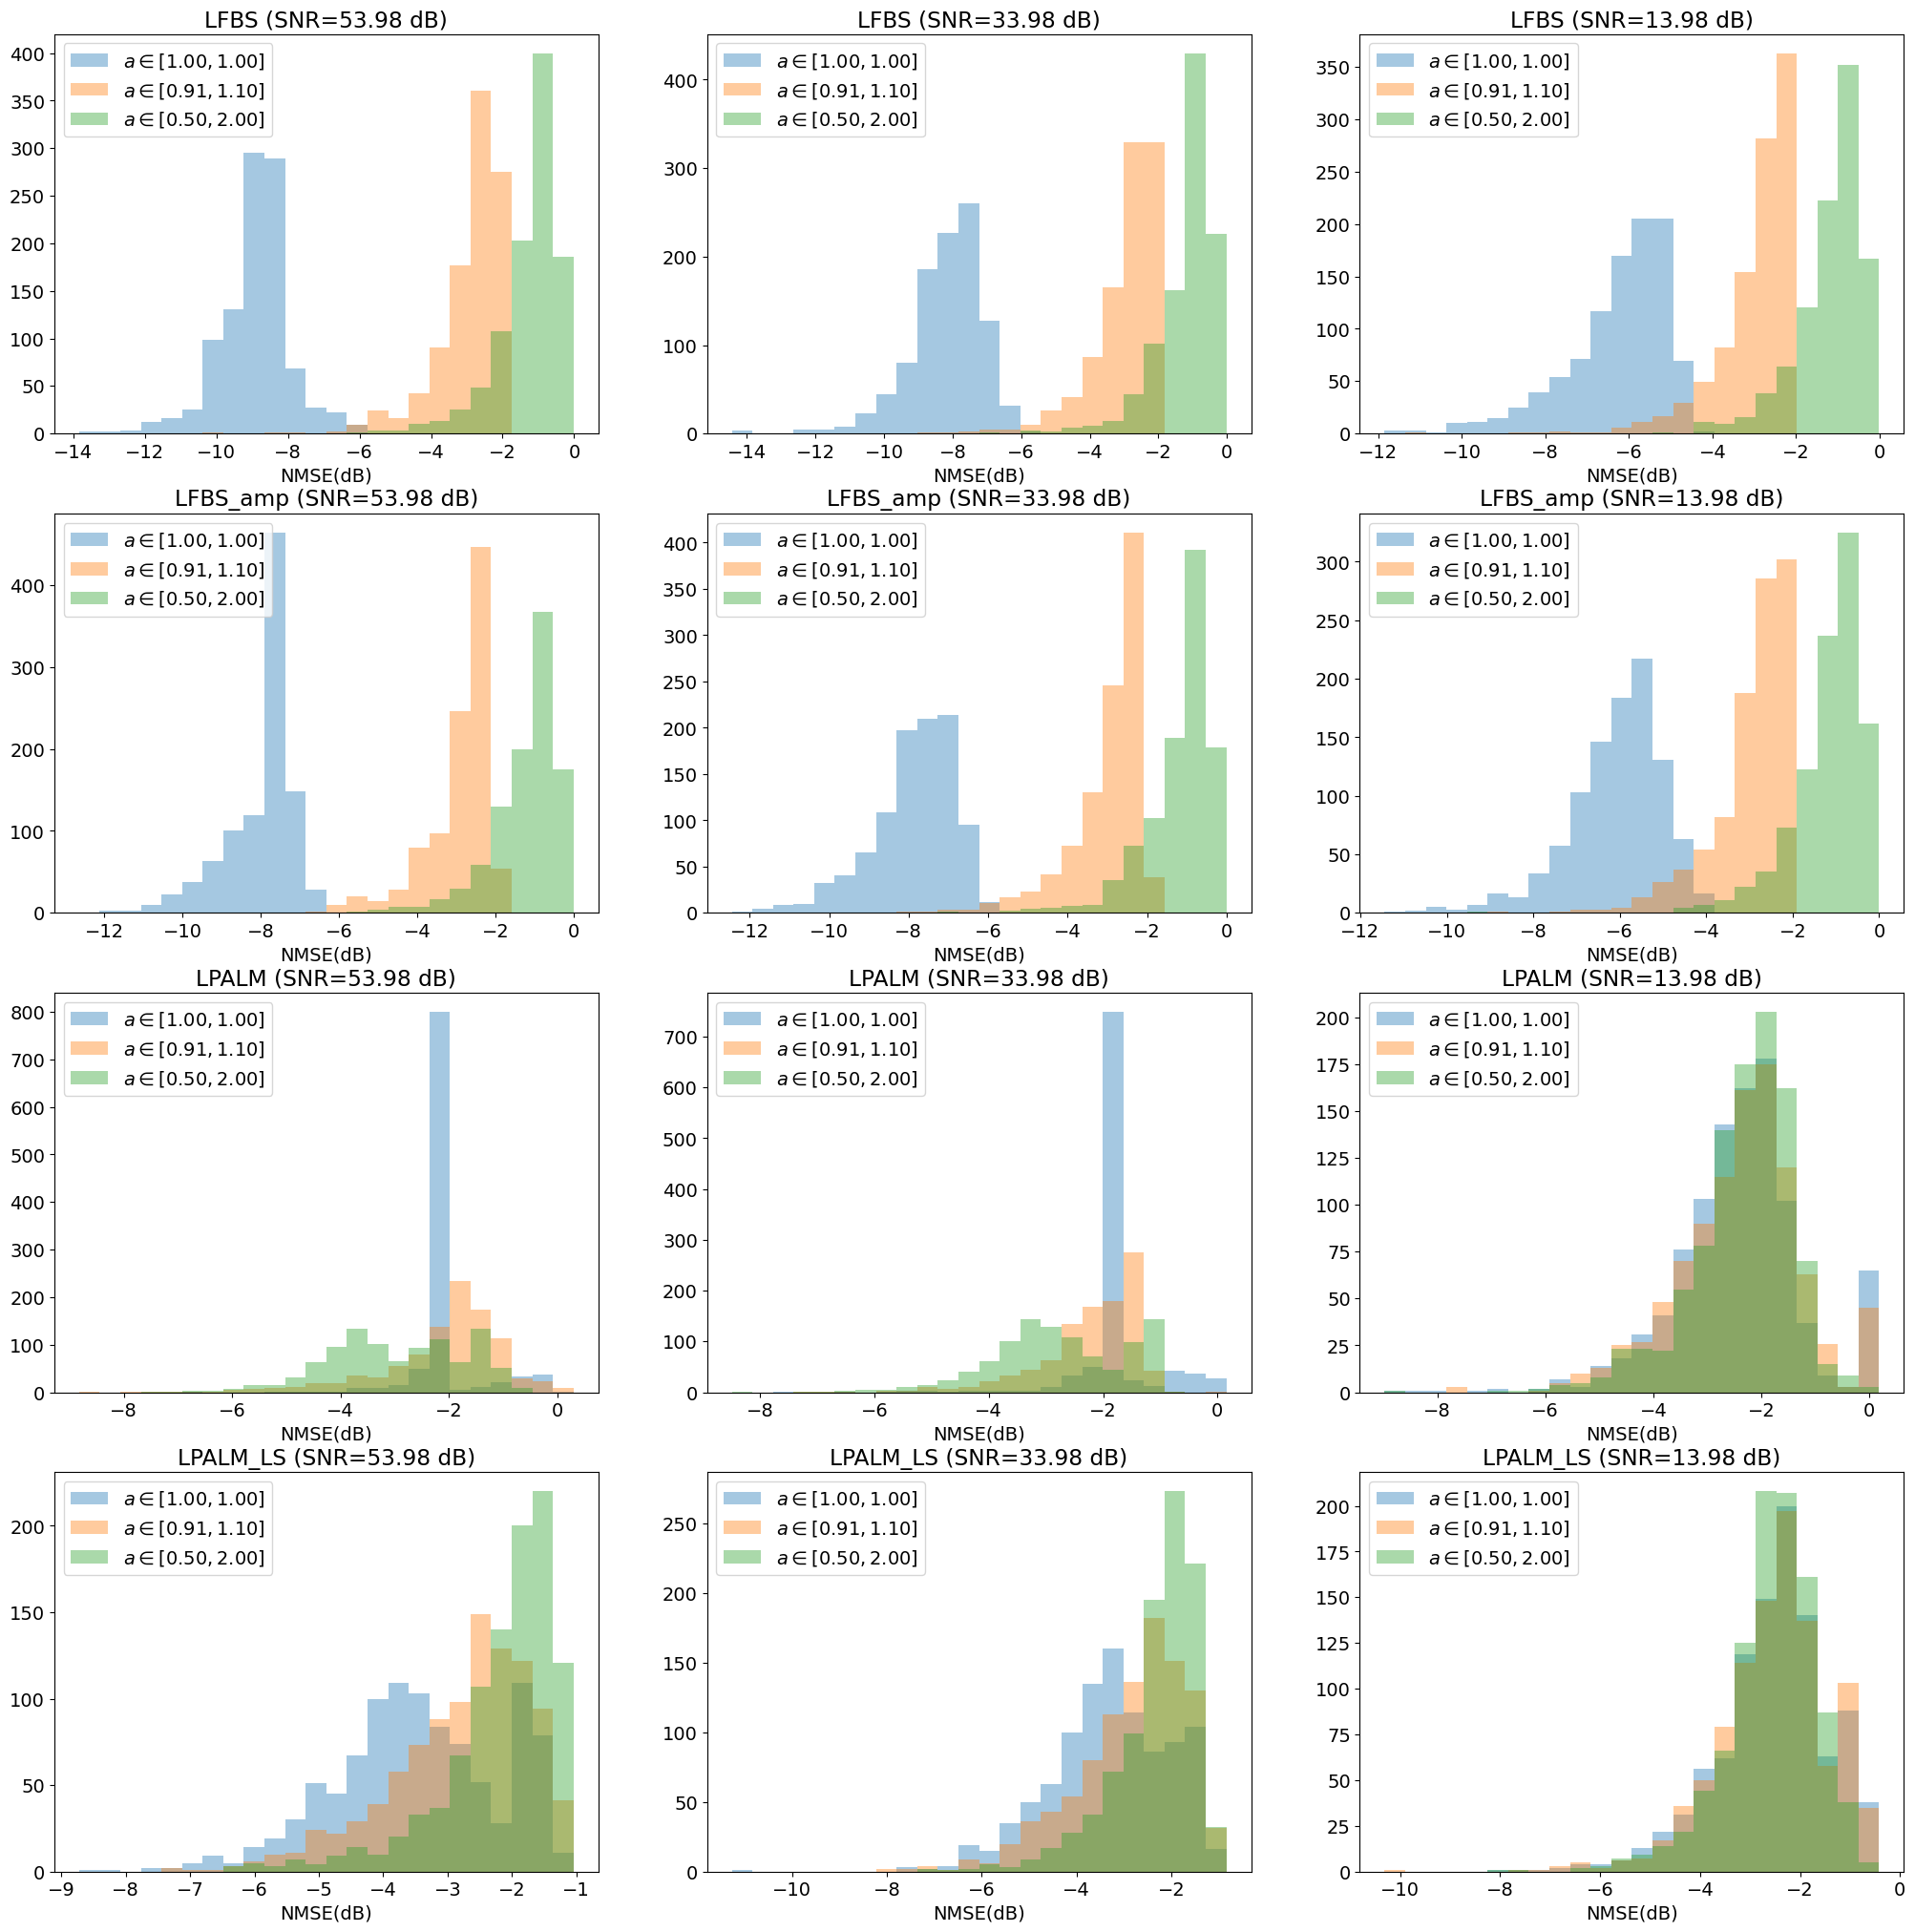

In [80]:
t = time.time()
plt.figure(figsize=(25,25))
i=0
for _noise_level in [1e-3,1e-2,1e-1]:

    nmse_x_LFBS=[]
    nmse_a_LFBS=[]
    nmse_x_LFBS_amp=[]
    nmse_a_LFBS_amp=[]
    nmse_x_LPALM_LS=[]
    nmse_a_LPALM_LS=[]
    nmse_x_LPALM=[]
    nmse_a_LPALM=[]
    for a in [1., 1.1, 2.]:
        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

        x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))
        nmse_x_LFBS.append(-10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LFBS.append(np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

        x_LFBS_amp = model_LFBS_amp.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS_amp = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS_amp.max(1))
        nmse_x_LFBS_amp.append(-10*np.log10(np.sum((x_LFBS_amp-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LFBS_amp.append(np.log10(np.sum((a_LFBS_amp-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

        a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
        x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()
        nmse_x_LPALM_LS.append(-10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LPALM_LS.append(np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

        a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM = a_LPALM[-1].cpu().detach().numpy()
        x_LPALM = x_LPALM[-1].cpu().detach().numpy()
        nmse_x_LPALM.append(-10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2))))
        nmse_a_LPALM.append(np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16))

    j=0
    for a in [1., 1.1, 2.]:
        plt.subplot(4,3,i+1)
        bins = np.linspace(np.array(nmse_a_LFBS).min(),np.array(nmse_a_LFBS).max(),25)
        plt.hist(nmse_a_LFBS[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LFBS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+4)
        bins = np.linspace(np.array(nmse_a_LFBS_amp).min(),np.array(nmse_a_LFBS_amp).max(),25)
        plt.hist(nmse_a_LFBS_amp[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LFBS_amp (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+7)
        bins = np.linspace(np.array(nmse_a_LPALM).min(),np.array(nmse_a_LPALM).max(),25)
        plt.hist(nmse_a_LPALM[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LPALM (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()
        plt.subplot(4,3,i+10)
        bins = np.linspace(np.array(nmse_a_LPALM_LS).min(),np.array(nmse_a_LPALM_LS).max(),25)
        plt.hist(nmse_a_LPALM_LS[j],bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LPALM_LS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()
        j+=1
    i+=1
# plt.savefig('./Figures/hist_robust_models_a.png', bbox_inches='tight')

print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

### histograms with same bins

Computation time with cuda: 5.505 s


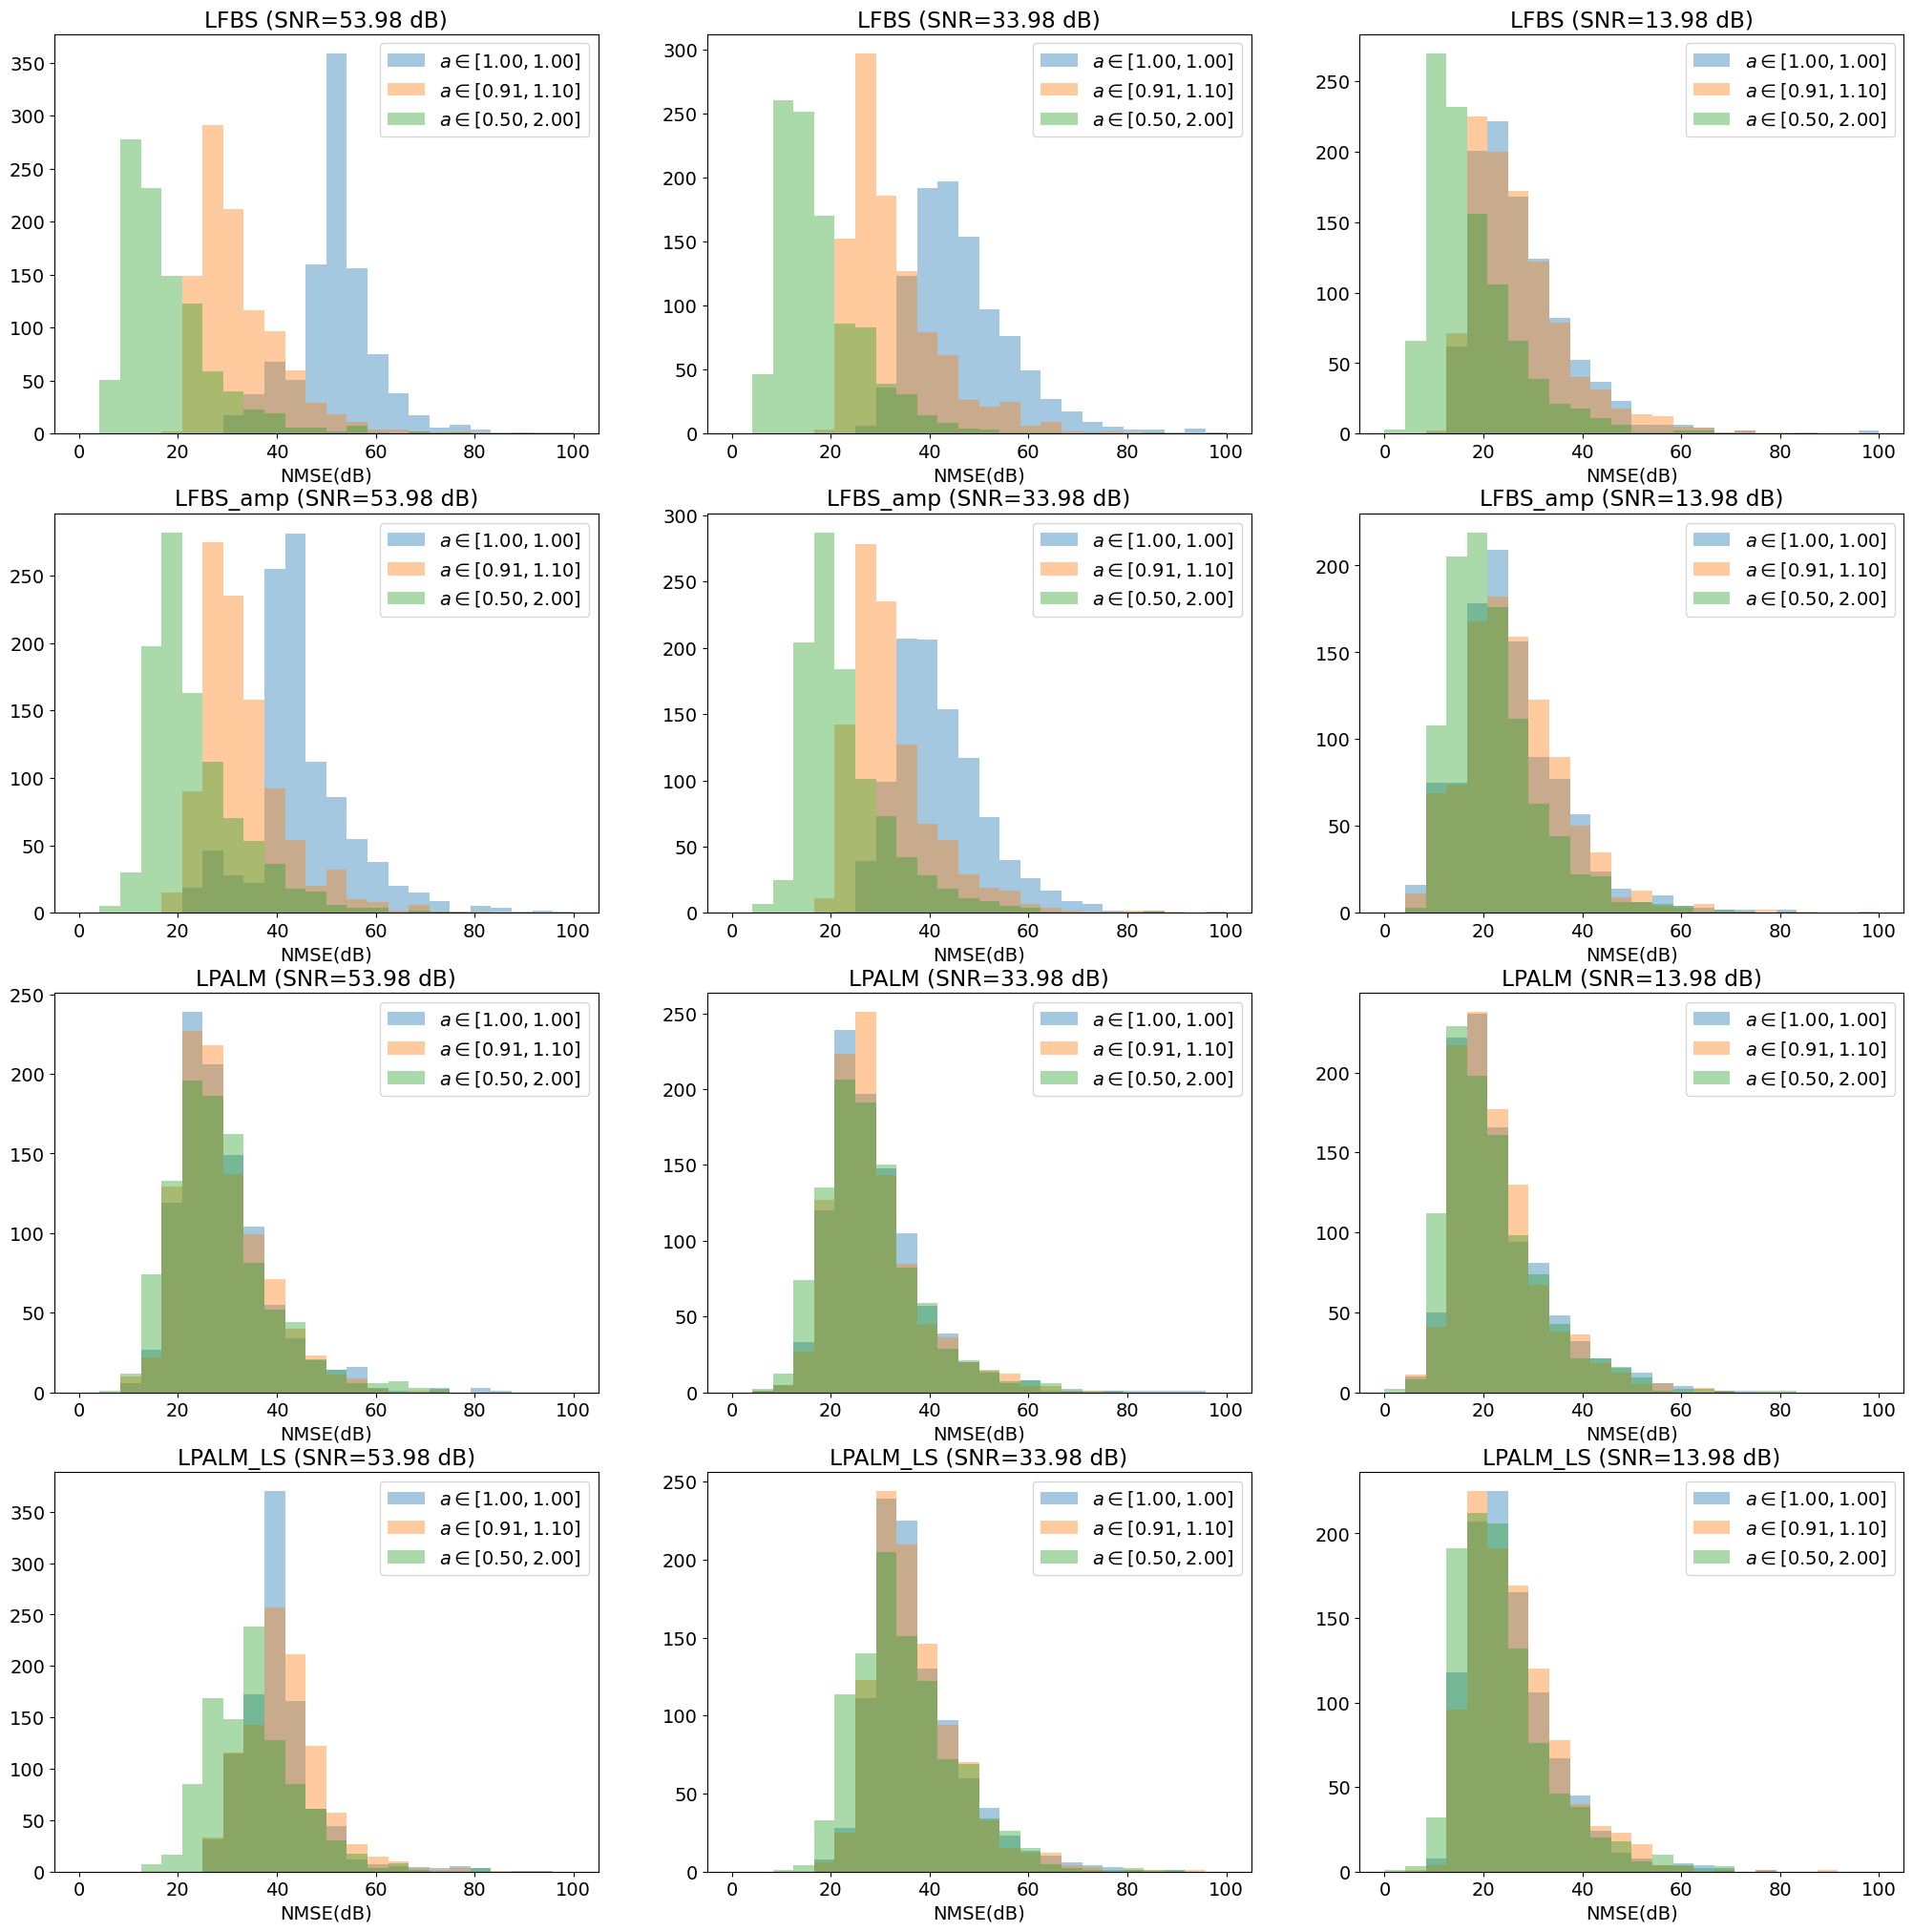

In [7]:
t = time.time()
plt.figure(figsize=(25,25))
i=0
bins = np.linspace(0,100,25)
for _noise_level in [1e-3,1e-2,1e-1]:
    for a in [1., 1.1, 2.]:
        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

        x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))
        nmse_x_LFBS = -10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS = np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        x_LFBS_amp = model_LFBS_amp.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS_amp = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS_amp.max(1))
        nmse_x_LFBS_amp = -10*np.log10(np.sum((x_LFBS_amp-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS_amp = np.log10(np.sum((a_LFBS_amp-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
        x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()
        nmse_x_LPALM_LS = -10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM_LS = np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM = a_LPALM[-1].cpu().detach().numpy()
        x_LPALM = x_LPALM[-1].cpu().detach().numpy()
        nmse_x_LPALM = -10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM = np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        plt.subplot(4,3,i+1)
        plt.hist(nmse_x_LFBS ,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LFBS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+4)
        plt.hist(nmse_x_LFBS_amp ,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LFBS_amp (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+7)
        plt.hist(nmse_x_LPALM ,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LPALM (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+10)
        plt.hist(nmse_x_LPALM_LS ,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('NMSE(dB)')
        plt.title('LPALM_LS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()
    i+=1
# plt.savefig('./Figures/hist_robust_models2.png', bbox_inches='tight')

print('Computation time with ' + device + ': %.3f s'% (time.time()-t))

Computation time with cuda: 5.797 s


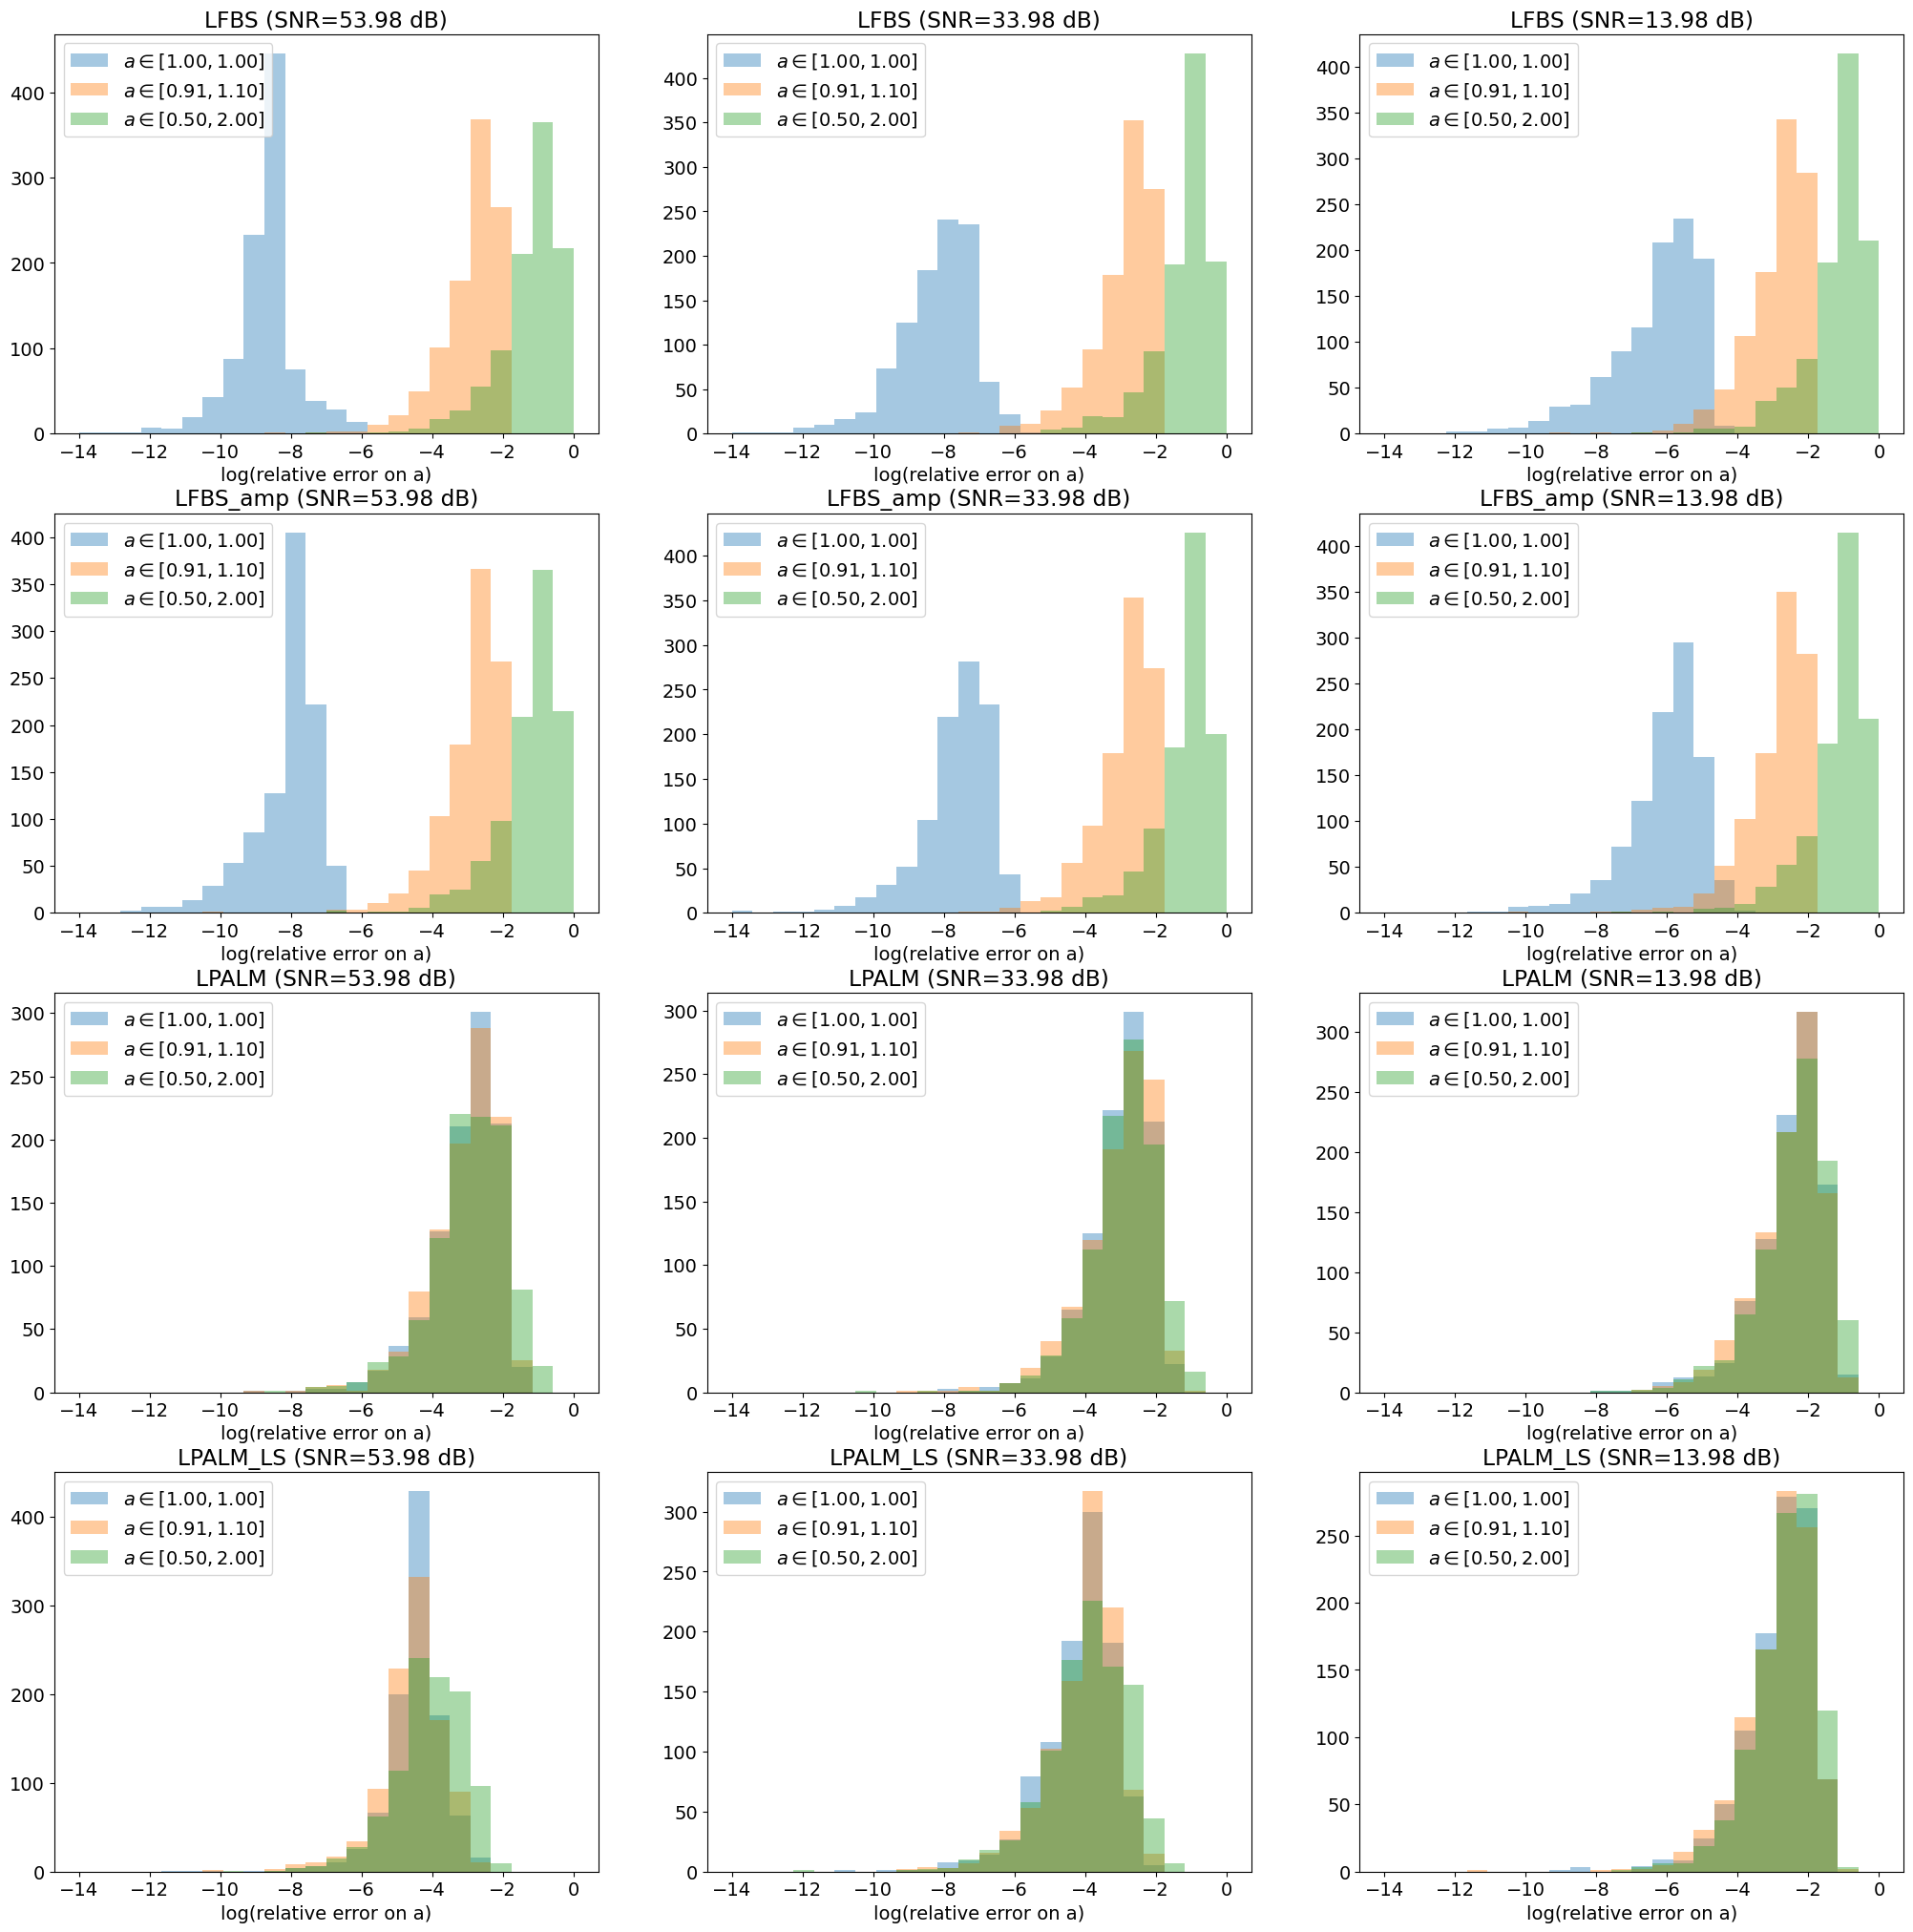

In [8]:
t = time.time()
plt.figure(figsize=(25,25))
i=0
bins = np.linspace(-14,0,25)
for _noise_level in [1e-3,1e-2,1e-1]:
    for a in [1., 1.1, 2.]:
        Ytest, Atest, Xtest = generate_dataset(model_IAE, 1000, noise_level = [_noise_level, _noise_level], amplitude_range=a)
        dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Xtest).float()), batch_size=50)

        x_LFBS = model_LFBS.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS.max(1))
        nmse_x_LFBS = -10*np.log10(np.sum((x_LFBS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS = np.log10(np.sum((a_LFBS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        x_LFBS_amp = model_LFBS_amp.forward(torch.tensor(Ytest).float().to(device))[-1].cpu().detach().numpy()
        a_LFBS_amp = np.einsum('ij,ij->ij',Xtest.max(1), 1./x_LFBS_amp.max(1))
        nmse_x_LFBS_amp = -10*np.log10(np.sum((x_LFBS_amp-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LFBS_amp = np.log10(np.sum((a_LFBS_amp-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM_LS, x_LPALM_LS = model_LPALM_LS.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM_LS = a_LPALM_LS[-1].cpu().detach().numpy()
        x_LPALM_LS = x_LPALM_LS[-1].cpu().detach().numpy()
        nmse_x_LPALM_LS = -10*np.log10(np.sum((x_LPALM_LS-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM_LS = np.log10(np.sum((a_LPALM_LS-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        a_LPALM, x_LPALM = model_LPALM.forward(torch.tensor(Ytest).float().to(device))
        a_LPALM = a_LPALM[-1].cpu().detach().numpy()
        x_LPALM = x_LPALM[-1].cpu().detach().numpy()
        nmse_x_LPALM = -10*np.log10(np.sum((x_LPALM-Xtest)**2, (1,2))/ np.sum(Xtest**2, (1,2)))
        nmse_a_LPALM = np.log10(np.sum((a_LPALM-Atest)**2, 1)/ np.sum(Atest**2, 1)+1e-16)

        plt.subplot(4,3,i+1)
        plt.hist(nmse_a_LFBS,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('log(relative error on a)')
        plt.title('LFBS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+4)
        plt.hist(nmse_a_LFBS_amp,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('log(relative error on a)')
        plt.title('LFBS_amp (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()

        plt.subplot(4,3,i+7)
        plt.hist(nmse_a_LPALM,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('log(relative error on a)')
        plt.title('LPALM (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()
        
        plt.subplot(4,3,i+10)
        plt.hist(nmse_a_LPALM_LS,bins,alpha=0.4,label='$a \in [%.2f, %.2f]$'%(1/a,a))
        plt.xlabel('log(relative error on a)')
        plt.title('LPALM_LS (SNR=%.2f dB)'%(20*np.log10(0.5/_noise_level)))
        plt.legend()
    i+=1
# plt.savefig('./Figures/hist_robust_models2_a.png', bbox_inches='tight')

print('Computation time with ' + device + ': %.3f s'% (time.time()-t))